# IMPORT

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import display
from IPython.display import HTML
from scipy.cluster.hierarchy import fcluster

# List of all paths
paths = [
    "C:/Users/dani/inference/AI-city/inference_results.csv",
    "C:/Users/dani/inference/multistream/inference_results.csv",
    "C:/Users/dani/inference/WALT-journal/inference_results.csv",
    "C:/Users/dani/inference/WALT-journalV/inference_results.csv",
    "C:/Users/dani/inference/WALT-poolbased/inference_results.csv"
]

# List to hold dataframes
dfs = []

# Loop through paths and read the data
for path in paths:
    dfs.append(pd.read_csv(path))

# Concatenate all the dataframes into one
df_all = pd.concat(dfs, ignore_index=True)
df_all['source_combo'] = list(zip(df_all['source_domain'], df_all['source_period']))

### FORMATTING OPTIONS
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))


#### IMAGE DESTINATION FOLDER ###

fig_dst_path="E:\\Download\\images-journal\\"

# UTILS


In [55]:
def benchmark_strategies_plot(strategies_df,
                              strategy_styles,
                              plot_style=None,
                              baseline_df=None,
                              baseline_styles=None,
                              random_df=None,
                              prefix_random=None):
    # Group by strategy and sample and calculate average 'mAP50-95'
    grouped_df = strategies_df.groupby(['strategy', 'samples']).mean(numeric_only=True)['mAP50-95'].reset_index()

    # Pivot to wide format for plotting
    pivot_df = grouped_df.pivot(index='samples', columns='strategy', values='mAP50-95')

    # Plot
    plt.figure(figsize=(8, 6), dpi=300)
    ax = plt.gca()  # get the current axes, creating them if necessary
    for column in pivot_df.columns:
        style = strategy_styles.get(column, {})
        plt.plot(pivot_df.index, pivot_df[column], 
                 style.get('color', 'black'),
                 marker=style.get('marker', ''),
                 markersize=style.get('markersize',5),
                 linewidth=2, 
                 label=style.get('label',column))
    
    if baseline_df is not None:
        # Calculate average 'mAP50-95' for each strategy
        baseline_df_avg = baseline_df.groupby('strategy').mean(numeric_only=True)['mAP50-95']
        # For each model, add a horizontal line across the entire x-axis range
        for strategy, avg_mAP in baseline_df_avg.items():
            # annotate the lines
            #plt.text(pivot_df.index.max(), avg_mAP, f"{strategy}: {avg_mAP:.2f}", color='blue', va='center', ha='left')
            if baseline_styles is not None:
                style_bs=baseline_styles.get(str(strategy),{})
                ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(),
                          colors=style_bs.get('color','black'), 
                          linestyles='dotted', 
                          alpha=1, linewidth=style_bs.get("linewidth",2), label=style_bs.get('label',""))
            else:
                ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(), colors='black', linestyles='dotted', alpha=1, linewidth=2)

                    


    # Add average and variance for 'uniform-random' strategies
    if random_df is not None:
        random_grouped = random_df.groupby('samples')['mAP50-95'].agg(['mean', 'std', 'count'])
        z_score_95_percent = 1.96
        moe = z_score_95_percent * (random_grouped['std'] / np.sqrt(random_grouped['count']))

        ax.plot(random_grouped.index, random_grouped['mean'], label=prefix_random, color='m', marker="d")

        # Use the 95% margin of error
        ax.fill_between(random_grouped.index, 
                        random_grouped['mean'] - moe, 
                        random_grouped['mean'] + moe, 
                        color='magenta', alpha=0.1, label='95% Margin of Error Random')


    # Set labels, legend, and title
    ax.legend()
    ax.set_title('Average mAP50-95 values per sample for different strategies', weight='bold', color='blue')
    ax.set_xlabel('Samples Budget', weight='bold')
    ax.set_ylabel('mAP50-95', weight='bold')
    ax.grid(True)
    if plot_style is not None:
        ax.set_xticks(plot_style.get('tick_positions'))
        ax.set_xticklabels(plot_style.get('tick_labels'))
        ax.set_title(plot_style.get('title','Average mAP50-95 values per sample for different strategies'),weight='bold', color='blue')
        ax.grid(plot_style.get('setGrid',True))
        ax.set_xlabel(plot_style.get('xlabel','Samples Budget'),weight='bold')
        plt.savefig(fname=plot_style.get("filename", "unknownfilename"), 
                                            format='pdf', 
                                            dpi=300)
    
    
    plt.show()
    

def compute_pivot_tables(strategies_df):
    # Compute groupby operations
    grouped_df_mean = strategies_df.groupby(['strategy', 'samples']).mean(numeric_only=True)['mAP50-95'].reset_index()
    grouped_df_std  = strategies_df.groupby(['strategy', 'samples']).std(numeric_only=True)['mAP50-95'].reset_index()
    grouped_df_count = strategies_df.groupby(['strategy', 'samples']).count()['mAP50-95'].reset_index()
    
    # Pivot to wide format
    pivot_df_mean = grouped_df_mean.pivot(index='samples', columns='strategy', values='mAP50-95')
    pivot_df_std = grouped_df_std.pivot(index='samples', columns='strategy', values='mAP50-95')
    pivot_df_count = grouped_df_count.pivot(index='samples', columns='strategy', values='mAP50-95')
    
    # Add prefixes to columns to distinguish the different metrics
    pivot_df_mean.columns = ["mean_" + col for col in pivot_df_mean.columns]
    pivot_df_std.columns = ["std_" + col for col in pivot_df_std.columns]
    pivot_df_count.columns = ["count_" + col for col in pivot_df_count.columns]

    # Concatenate DataFrames column-wise for each 'samples' value
    result_df = pd.concat([pivot_df_mean, pivot_df_std, pivot_df_count], axis=1)
    
    return result_df

def to_latex_mean_std(df, caption="", label="", rename_dict="", environment="table"):
    # Rename strategies for shorter/better display names
    if rename_dict:
        # Create a new DataFrame to hold mean ± std format
        result_df = pd.DataFrame(index=df.index)
        for old_name, new_name in rename_dict.items():
            mean_col = f"mean_{old_name}"
            std_col = f"std_{old_name}"
            
            # Format as "mean ± std"
            result_df[new_name] = df[mean_col].map('{:.3f}'.format) + " ± " + df[std_col].map('{:.2f}'.format)
    else:
        result_df = df.copy()
        
    # Get the number of columns and construct the column format string
    num_columns = result_df.shape[1]
    column_format = "|" + "c|" * (num_columns+1)
    
    # Convert to latex with Styler
    latex_str = result_df.style.to_latex(column_format=column_format, 
                                         position='htpb',
                                         label=label,
                                         caption=caption,
                                         hrules=True,
                                         clines="all;data",
                                         environment=environment)
    
    return latex_str#.replace("\\\\", "\\\\ \\hline").replace("\\bottomrule", "\\bottomrule \\bottomrule")


In [88]:
def filter_df(df, source_dataset=None, same_domain = False, strategies = None, 
              samples=None, source_periods=None, source_domains=None, 
              excluded_domains=None, dom_periods = None, 
              target_domain=None, students=None, teachers=None, prefix_random=None):        
    
    filtered_df = df
    
    if source_dataset is not None:
        filtered_df = filtered_df[filtered_df['source_dataset'].isin(source_dataset)]
        
    if strategies is not None:
        filtered_df = filtered_df[filtered_df['strategy'].isin(strategies)]
        
    if samples is not None: 
        filtered_df = filtered_df[filtered_df['samples'].isin(samples)]
        
    if same_domain:
        filtered_df = filtered_df[filtered_df['source_domain'] == filtered_df['target_domain']]
    
    if source_periods is not None:
        filtered_df = filtered_df[filtered_df['source_period'].isin(source_periods)]
    
    if source_domains is not None:
        filtered_df = filtered_df[filtered_df['source_domain'].isin(source_domains)]
    
    if excluded_domains is not None:
        filtered_df = filtered_df[~filtered_df['target_domain'].isin(excluded_domains)]
        
    if dom_periods is not None:
        filtered_df = filtered_df[filtered_df['source_combo'].isin(dom_periods)]
        
    if target_domain is not None:
        filtered_df = filtered_df[filtered_df['target_domain'].isin(target_domain)]
        
    if students is not None:
        filtered_df = filtered_df[filtered_df['student'].isin(students)]
    
    if teachers is not None:
        filtered_df = filtered_df[filtered_df['teacher'].isin(teachers)]
        
    if prefix_random is not None:
        filtered_df = filtered_df[filtered_df['strategy'].str.startswith(prefix_random)]
    
    return filtered_df, filtered_df['mAP50-95'].mean(), filtered_df['mAP50-95'].std()

In [6]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def perform_statistical_tests(df1, df2, df1_name, df2_name, suffix=''):
    if suffix:
        suffix = f'_{suffix}'
    
    if len(df1) < 3 or len(df2) < 3 or len(df1['mAP50-95']) == 0 or len(df2['mAP50-95']) == 0:
        return {
            f't-statistic{suffix}': None,
            f'p-value{suffix}': None,
            f'T-test result{suffix}': "Not testable",
            f'shapiro-wilk {df1_name}{suffix}': None,
            f'shapiro-wilk {df1_name} result{suffix}': "Not testable",
            f'shapiro-wilk {df2_name}{suffix}': None,
            f'shapiro-wilk {df2_name} result{suffix}': "Not testable",
            f'levene{suffix}': None,
            f'levene result{suffix}': "Not testable",
            f'mann-whitney u{suffix}': None,
            f'mann-whitney u result{suffix}': "Not testable"
        }

    t_statistic, p_value_t = ttest_ind(df1['mAP50-95'], df2['mAP50-95'])
    t_test_result = 'Means statistically different (reject H0)' if p_value_t < 0.05 else 'Means statistically undifferent'
    
    _, p_shapiro_df1 = shapiro(df1['mAP50-95'])
    shapiro_df1_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df1 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_shapiro_df2 = shapiro(df2['mAP50-95'])
    shapiro_df2_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df2 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_levene = levene(df1['mAP50-95'], df2['mAP50-95'])
    levene_result = 'Variances do not look equal (reject H0)' if p_levene < 0.05 else 'Variances look equal (fail to reject H0)'

    _, p_mannwhitney = mannwhitneyu(df1['mAP50-95'], df2['mAP50-95'])
    mannwhitney_result = 'Different distribution (reject H0)' if p_mannwhitney < 0.05 else 'Same distribution (fail to reject H0)'

    data = {
        f't-statistic{suffix}': t_statistic, 
        f'p-value{suffix}': p_value_t,
        f'T-test result{suffix}': t_test_result,
        f'shapiro-wilk {df1_name}{suffix}': p_shapiro_df1,
        f'shapiro-wilk {df1_name} result{suffix}': shapiro_df1_result,
        f'shapiro-wilk {df2_name}{suffix}': p_shapiro_df2,
        f'shapiro-wilk {df2_name} result{suffix}': shapiro_df2_result,
        f'levene{suffix}': p_levene,
        f'levene result{suffix}': levene_result,
        f'mann-whitney u{suffix}': p_mannwhitney,
        f'mann-whitney u result{suffix}': mannwhitney_result
    }

    return data

def conduct_anova_and_tukey(dataframe_list, names, alpha=0.1):
    """
    Conducts ANOVA and Tukey HSD tests on multiple dataframes.
    
    Args:
    dataframe_list: list of pandas dataframes to be analyzed.
    names: a list of strings, specifying the names (or sources) of the dataframes.
    alpha: significance level for the Tukey HSD test.
    
    Returns:
    a tuple (anova_result, tukey_results)
    """
    
    # Error checking: make sure we have as many names as dataframes in the list
    if len(dataframe_list) != len(names):
        raise ValueError("The number of dataframes should match the number of names.")
    
    # Add source column and combine dataframes
    combined_list = []
    for df, name in zip(dataframe_list, names):
        df_copy = df.copy()
        df_copy['source'] = name
        combined_list.append(df_copy)
        
    combined_df = pd.concat(combined_list, ignore_index=True)
    
    # Rename mAP50-95 column for compatibility with patsy formula
    combined_df.rename(columns={'mAP50-95': 'mAP50_95'}, inplace=True)
    
    # Conduct ANOVA
    model = ols('mAP50_95 ~ source', data=combined_df).fit()
    anova_result = sm.stats.anova_lm(model, typ=2)
    
    # Create lists for the Tukey HSD test
    values = combined_df['mAP50_95'].tolist()
    labels = combined_df['source'].tolist()
    
    # Conduct Tukey HSD test
    tukey_results = pairwise_tukeyhsd(values, labels, alpha=alpha)
    
    return anova_result, tukey_results

The present work provides a comprehensive analysis of 

This work investigate the claim of the SBAD framework and aim to provide comprehensive analysis of
1. The scalability of the SBAD framework by completing the experiments on 9 cameras
2. Investigating the specialization claim. 
3. Quantifying the confirmation bias


The equation **sample big enough and diversity** remains the key for good fine-tuning. 

<h1><font color="blue"> 1. SCALE OF SBAD EXPERIMENT UP TO 9 CAMERAS </font><h1>



<h2><font color="blue"> 1.2 Methodology </font><h2>

There are two sets of cameras-weeks pairs and they. The first set (_extensive set_) is comprised of all the eligible cameras and weeks pais. The eligibility has been determined whether on simple criterion as enough samples to launch the strategies as well as not being part of the test set. 
    
The _restricted_ dataset involves one week per camera and arbitrarily the first week of the later.

In [96]:
# Create a list of domains and periods for which we want to filter
scal_dom_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                    ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                    ('cam3', 'week5'), 
                    ('cam4', 'week2'), ('cam4', 'week3'), 
                    ('cam5', 'week3'), 
                    ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                    ('cam7', 'week4'), 
                    ('cam8', 'week3'), 
                    ('cam9', 'week1'),('cam9', 'week2')]

restricted_dom_periods  = [('cam1', 'week1'), 
                           ('cam2', 'week1'),
                           ('cam3', 'week5'), 
                           ('cam4', 'week2'),
                           ('cam5', 'week3'), 
                           ('cam6', 'week4'), 
                           ('cam7', 'week4'), 
                           ('cam8', 'week3'), 
                           ('cam9', 'week1')]

strategies_sb = ['n-first', 'thresholded-top-confidence-max', 'thresholded-least-confidence-max']
prefix_random_sb = 'uniform-random'
samples_small = [16, 32, 48, 64, 80, 96, 128, 216, 256]


BASE_MODELS = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x6']


MODELS_TO_PLOT = ['yolov8n', 'yolov8x6']
#Baseline
df_baseline_default, _ , _ = filter_df(df_all, 
                               source_dataset=['WALT'],
                               strategies=MODELS_TO_PLOT)

samples_large = [250, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
prefix_random_pb="random"

baseline_styles_default = {
    'yolov8n': {'color': 'k', 'marker': "",'label':'Student (yolov8n)','linewidth':2},
    'yolov8x6': {'color': 'r', 'marker': "",'label':'Teacher (yolov8x6)','linewidth':4},
}

 <h2> <font color="blue"> 1.3.Stream-based strategies </font><h2>

 <h3> <font color="blue"> 1.3.1.  Strategies vs samples plot </font><h3>

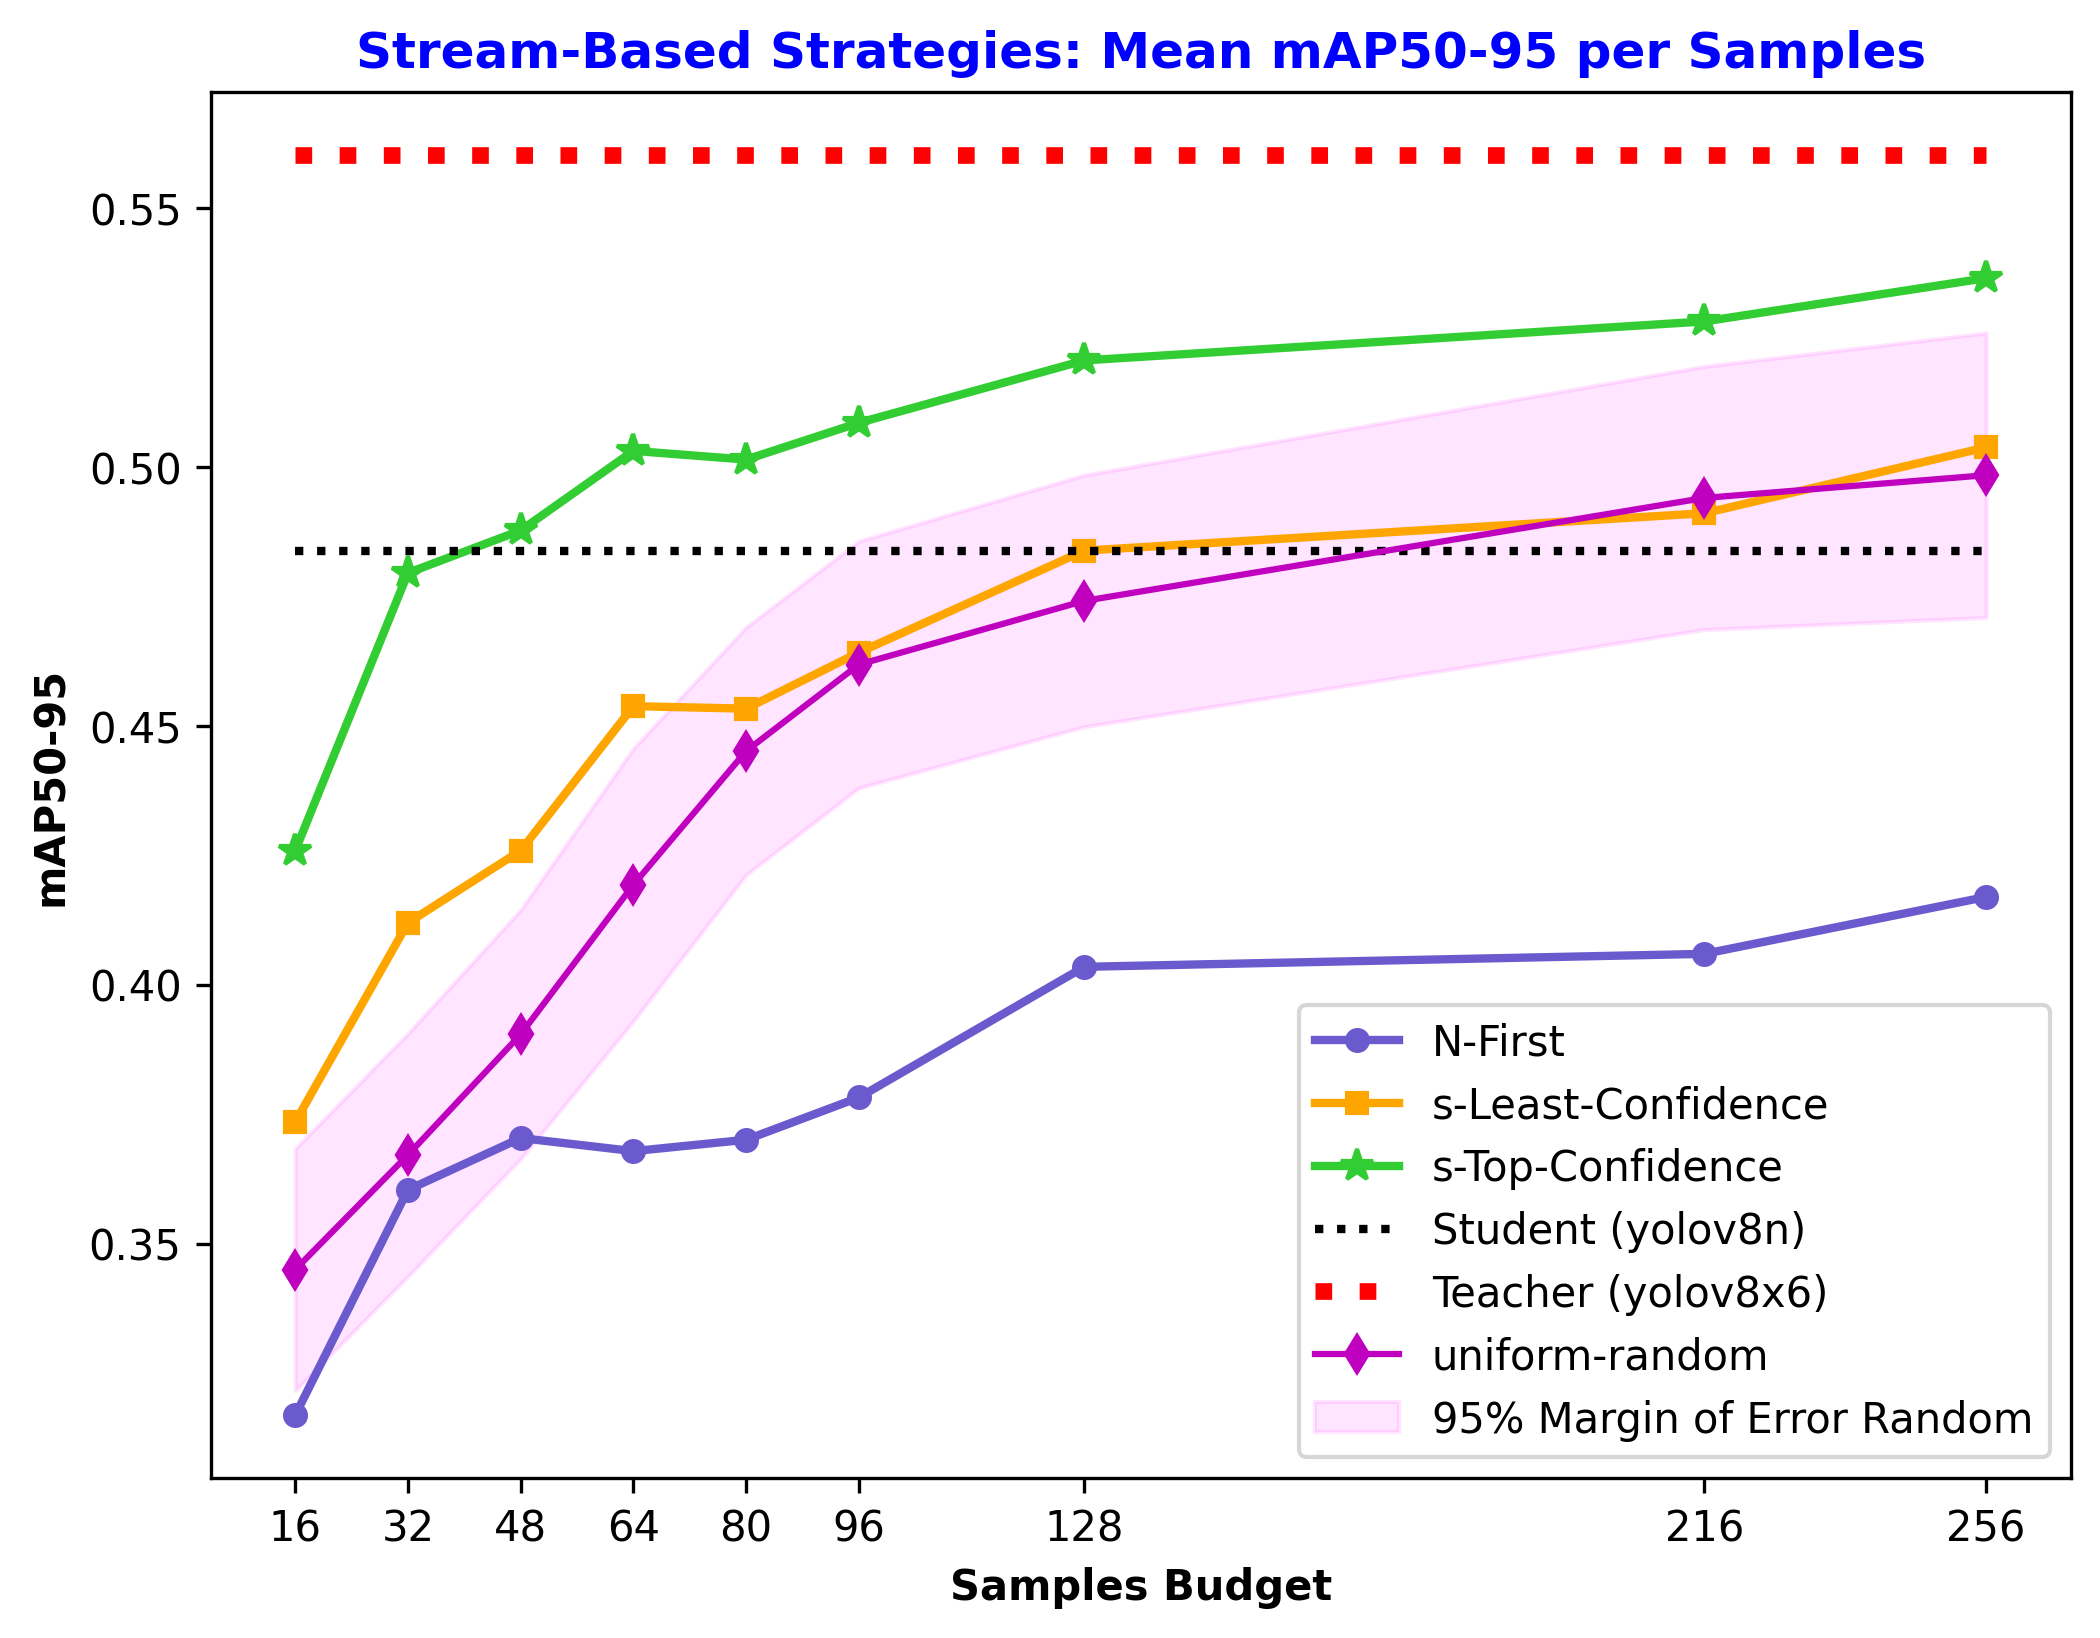

In [93]:
# Filter for a specific sample, strategy, and the domain-period combinations
df_strategies_sb, _ , _  = filter_df(df_all,
                                     same_domain=True,
                                     strategies=strategies_sb,
                                     samples=samples_small,
                                     dom_periods=scal_dom_periods,
                                     students=['yolov8n'],
                                     teachers=['yolov8x6'])


df_random_sb, _ , _ = filter_df(df_all, 
                      same_domain=True,
                      samples=samples_small,
                      dom_periods=scal_dom_periods,
                      prefix_random=prefix_random_sb)


sb_strategy_styles = {
    'n-first': {'color': 'slateblue', 'marker': 'o','label':'N-First'},
    'thresholded-top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'s-Top-Confidence','markersize':8},
    'thresholded-least-confidence-max': {'color': 'orange', 'marker': 's','label':'s-Least-Confidence'},
}


plot_style={
    'tick_positions' : samples_small,
    'tick_labels':[str(value) for value in samples_small],
    'title': 'Stream-Based Strategies: Mean mAP50-95 per Samples',
    'setGrid': False,
    'filename':"E:\Download\images-journal\sbstrategies.pdf"
}


pv=benchmark_strategies_plot(df_strategies_sb,
                          strategy_styles=sb_strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_sb,
                          prefix_random=prefix_random_sb)

In [158]:
rename_dict = {
    'n-first': 'n-first',
    'thresholded-least-confidence-max': 'thresh-least-confidence',
    'thresholded-top-confidence-max': 'thres-top-confidence'
}
caption = "Value of the stream-based strategies versus samples"
label = "tab:sbstrategies"
pivot_tbl_strat_sb = compute_pivot_tables(df_strategies_sb)
latex_output = to_latex_mean_std(pivot_tbl_strat_sb, caption=caption, label=label, rename_dict=rename_dict)
rename_dict_random = {
    'uniform-random-0': '0',
    'uniform-random-1': '1',
    'uniform-random-2': '2',
    'uniform-random-3': '3',
    'uniform-random-4': '4',
    'uniform-random-5': '5',
}

pivot_table_random_sb = compute_pivot_tables(df_random_sb)
caption_random = "Values of the uniform-random per seed versus samples"
label_random = "tab:sbstrategies_random"
latex_output_random = to_latex_mean_std(pivot_table_random_sb, 
                                         caption=caption_random, 
                                         label=label_random,
                                         rename_dict=rename_dict_random,
                                         environment="sidewaystable")

rename_dict_total = {
    'n-first': 'n-first',
    'thresholded-least-confidence-max': 'thresh-least-confidence',
    'thresholded-top-confidence-max': 'thres-top-confidence',
    'uniform-random-0': '0',
    'uniform-random-1': '1',
    'uniform-random-2': '2',
    'uniform-random-3': '3',
    'uniform-random-4': '4',
    'uniform-random-5': '5',
}

result_df_total= pd.merge(pivot_tbl_strat_sb, pivot_table_random_sb, on='samples', how='outer')
display(result_df_total)
caption_total= "Values of thetotalper seed versus samples"
label_total = "tab:sbstrategies_total"
latex_output_total= to_latex_mean_std(result_df_total, 
                                         caption=caption_total, 
                                         label=label_total,
                                         rename_dict=rename_dict_total,
                                         environment="sidewaystable")



#display(pivot_tbl_strat_sb)


#print(latex_output)
#print(latex_output_random)

#print(latex_output_total)

,mean_n-first,mean_thresholded-least-confidence-max,mean_thresholded-top-confidence-max,std_n-first,std_thresholded-least-confidence-max,std_thresholded-top-confidence-max,count_n-first,count_thresholded-least-confidence-max,count_thresholded-top-confidence-max,mean_uniform-random-0,...,std_uniform-random-2,std_uniform-random-3,std_uniform-random-4,std_uniform-random-5,count_uniform-random-0,count_uniform-random-1,count_uniform-random-2,count_uniform-random-3,count_uniform-random-4,count_uniform-random-5
samples,,,,,,,,,,,,,,,,,,,,,
16,0.317,0.373,0.426,0.152,0.158,0.114,19,19,19,0.368,...,0.134,0.121,0.122,0.113,19,13,18,17,17,17
32,0.360,0.412,0.480,0.135,0.152,0.102,19,19,19,0.387,...,0.138,0.128,0.117,0.112,18,11,18,18,17,17
48,0.370,0.426,0.488,0.153,0.140,0.109,19,19,19,0.407,...,0.125,0.126,0.122,0.137,18,13,14,18,18,18
64,0.368,0.454,0.503,0.153,0.133,0.102,19,19,19,0.430,...,0.116,0.126,0.142,0.130,19,10,14,16,15,13
80,0.370,0.453,0.501,0.151,0.148,0.106,19,19,19,0.456,...,0.150,0.122,0.124,0.119,19,11,12,18,18,18
96,0.378,0.464,0.509,0.149,0.141,0.111,19,19,19,0.470,...,0.146,0.117,0.134,0.121,19,13,16,18,18,18
128,0.403,0.484,0.521,0.128,0.127,0.105,18,19,19,0.483,...,0.139,0.136,0.140,0.123,19,13,16,19,19,18
216,0.406,0.491,0.528,0.152,0.123,0.104,19,19,19,0.492,...,0.139,0.126,0.132,0.134,19,9,14,18,18,18
256,0.417,0.504,0.536,0.147,0.119,0.110,19,19,19,0.505,...,0.147,0.149,0.135,0.149,19,9,14,18,18,18


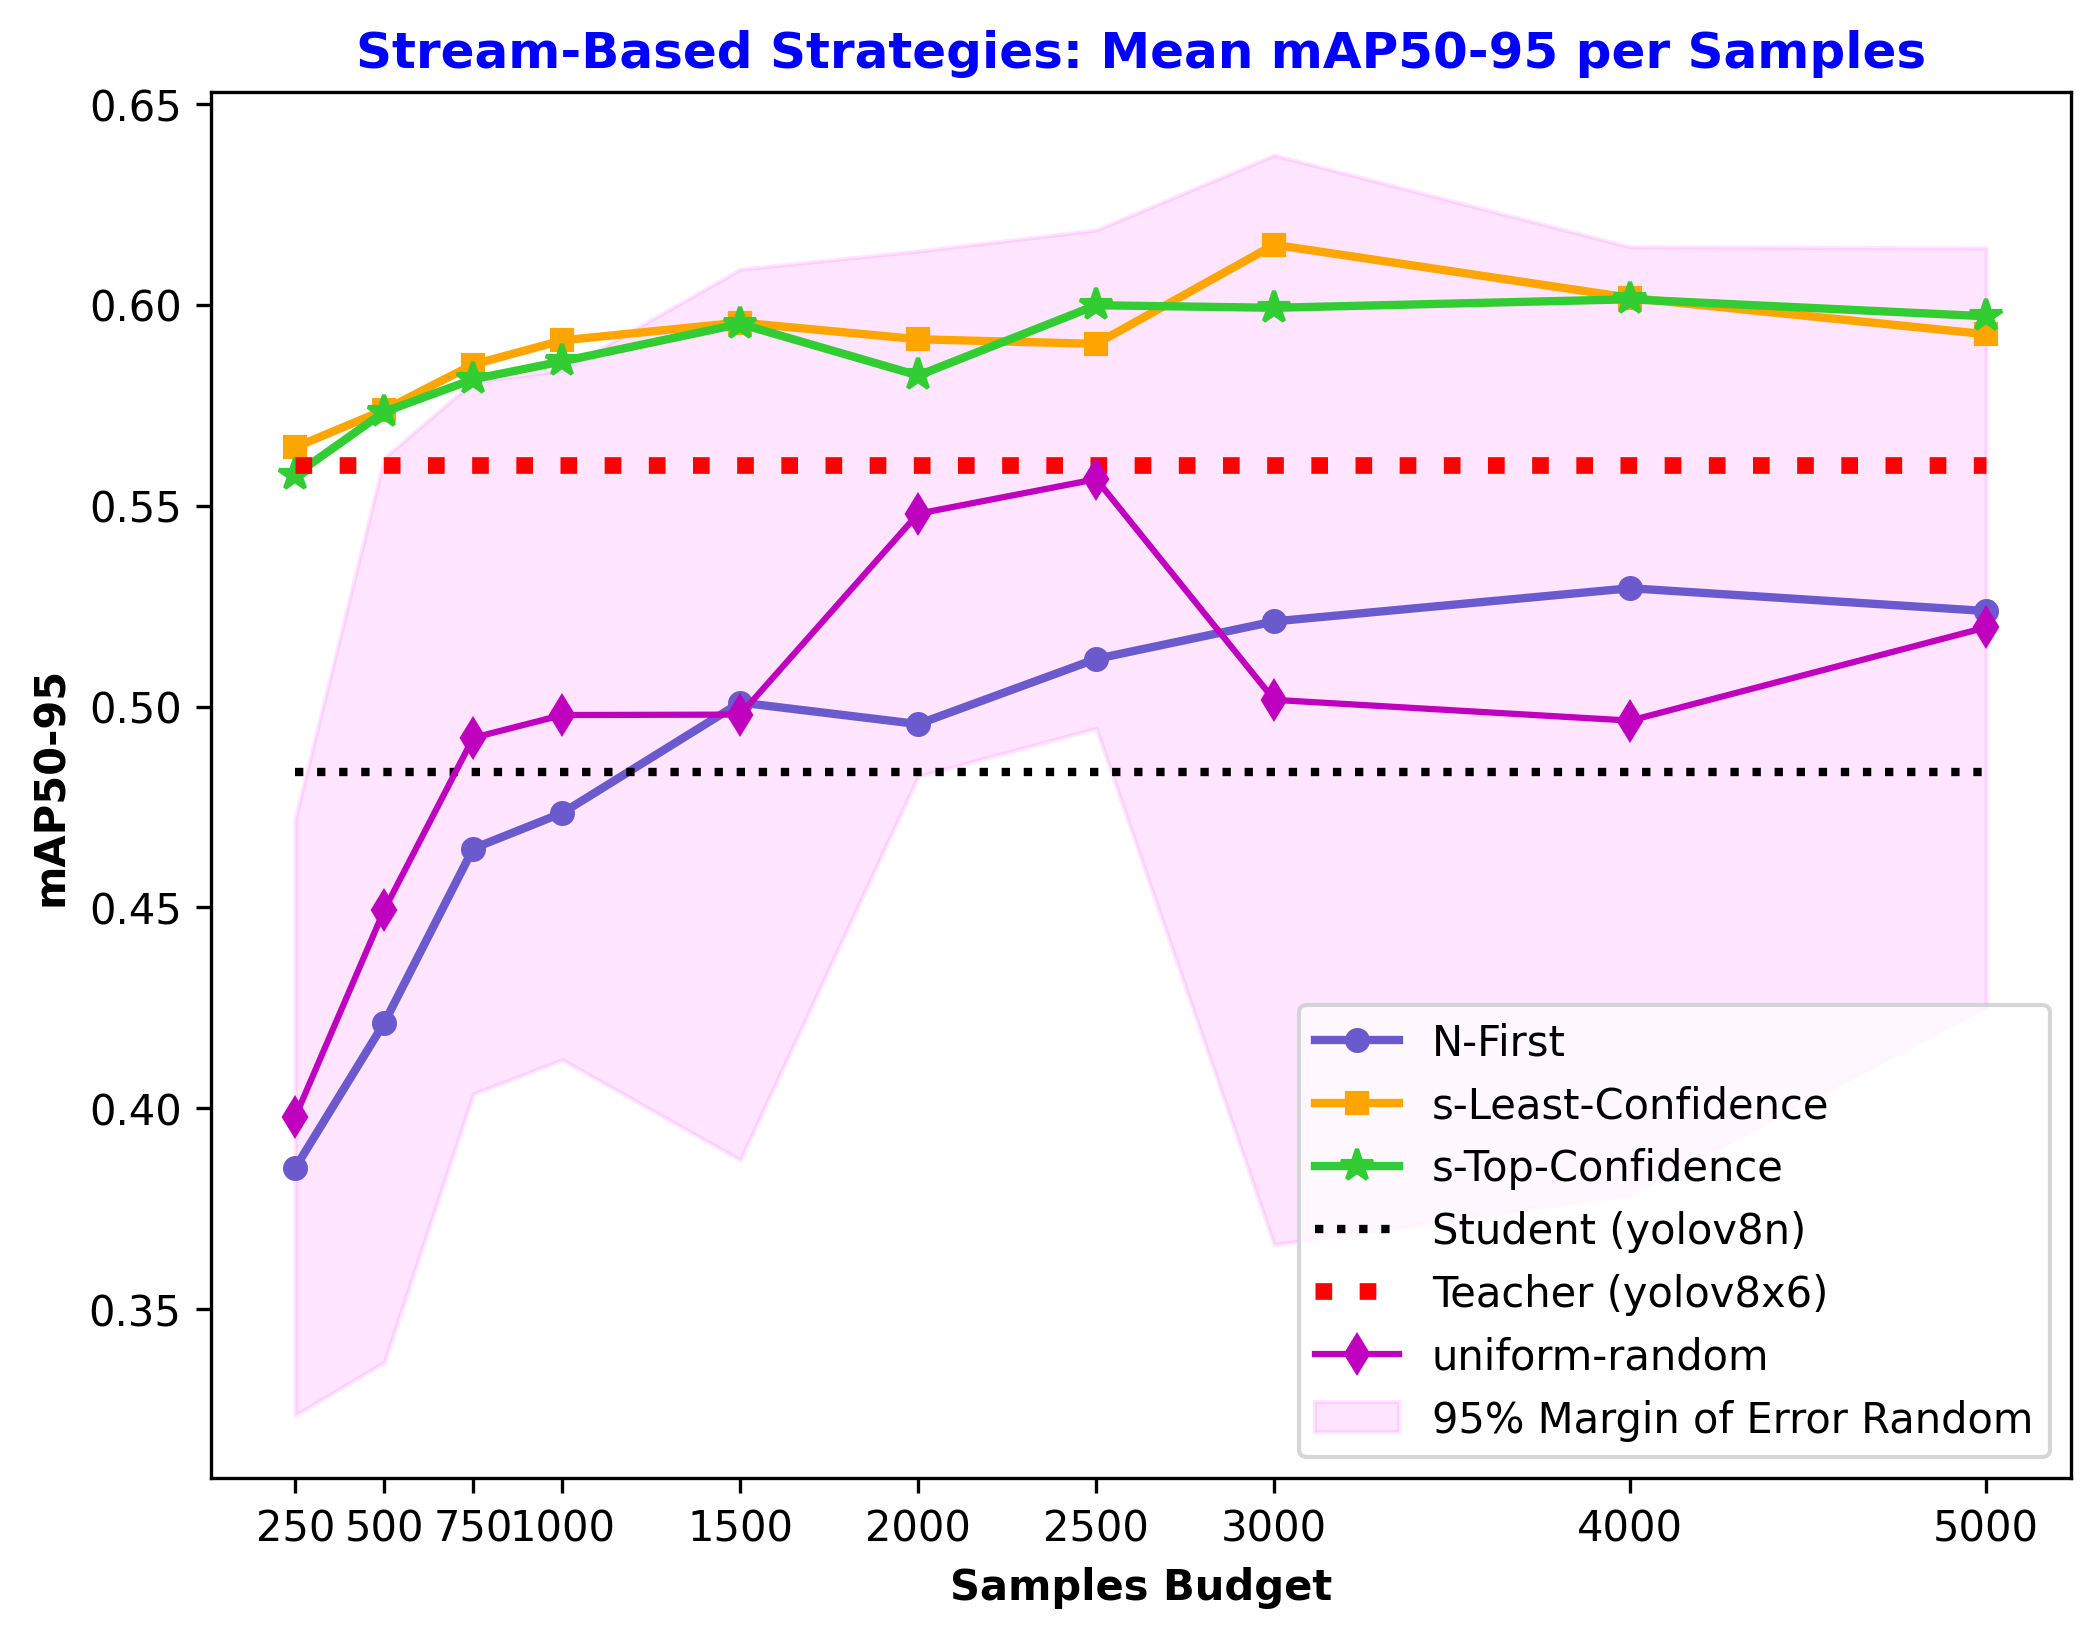

In [101]:
# Filter for a specific sample, strategy, and the domain-period combinations

strategies_sb = ['n-first', 'thresholded09160-top-confidence-max', 'thresholded09160-least-confidence-max']

df_strategies_largesb, _ , _  = filter_df(df_all,
                                     same_domain=True,
                                     strategies=strategies_largesb,
                                     samples=samples_large,
                                     dom_periods=scal_dom_periods,
                                     students=['yolov8n'],
                                     teachers=['yolov8x6'])


df_random_largesb, _ , _ = filter_df(df_all, 
                      same_domain=True,
                      samples=samples_large,
                      dom_periods=scal_dom_periods,
                      prefix_random=prefix_random_sb)


sb_strategy_styles = {
    'n-first': {'color': 'slateblue', 'marker': 'o','label':'N-First'},
    'thresholded09160-top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'s-Top-Confidence','markersize':8},
    'thresholded09160-least-confidence-max': {'color': 'orange', 'marker': 's','label':'s-Least-Confidence'},
}


plot_style={
    'tick_positions' : samples_large,
    'tick_labels':[str(value) for value in samples_large],
    'title': 'Stream-Based Strategies: Mean mAP50-95 per Samples',
    'setGrid': False,
    'filename':"E:\Download\images-journal\sbstrategies.pdf"
}


pv=benchmark_strategies_plot(df_strategies_largesb,
                          strategy_styles=sb_strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_largesb,
                          prefix_random=prefix_random_sb)

 <h3> <font color="blue"> 1.3.3.  Results analysis -stream-based scenarios </font><h3>

The analysis shows that selecting the frames where the student is the most confident remains the best strategy and confirms SBAD results. 



 <h2> <font color="blue"> 1.2. Statistical analysis </font><h2>

In [107]:
sample = [256]
strategy1=['thresholded-top-confidence-max']
str1_short='top-conf'
strategy2=['thresholded-least-confidence-max']
str2_short='least-conf'
strategy3=['n-first']
str3_short='nfirst'


strat1_df, mean_strat1, std_strat1 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy1,
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

strat2_df,mean_strat2, std_strat2= filter_df(df_stream,
                                             same_domain=True,
                                             strategies=strategy2, 
                                             samples=sample,
                                             dom_periods=restricted_dom_periods)
            
strat3_df, mean_strat3, std_strat3 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy3, 
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

yolov8n_df, mean_yolov8n, c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8n'],
                                        samples=[0])

yolov8x6_df,mean_yolov8x6,c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8x6'],samples=[0])

stats_data = perform_statistical_tests(strat1_df, strat3_df, str1_short, str3_short)

data = {'samples': sample, 
        'strategy1': strategy1,
        'strategy2':strategy2,
        'strategy3':strategy3,
        'mean_strat1': mean_strat1,
        'std_strat1': std_strat1,
        'mean_strat2': mean_strat2,
        'std_strat2': std_strat2,
        'mean_strat3': mean_strat3,
        'std_strat3': std_strat3,
        'mean_yolov8n': mean_yolov8n,
        'mean_yolov8x6': mean_yolov8x6,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
#display(formatted_data)


dataframes = [strat1_df, strat2_df, strat3_df, yolov8n_df, yolov8x6_df]
names = [str1_short, str2_short, str3_short, 'yolov8n', 'yolov8x6']

anova_res, tukey_res = conduct_anova_and_tukey(dataframes, names, alpha=0.05)


#print(anova_res)
#print(tukey_res)

In average, 

1. top and least-confidence strategies offers better performance after fine-tuning with superiority of the top. 
2. A bad sampling destroys the model. One should be careful. 
3. The difference is not statistically significative. Though, we can't assume at this stage normality of the distribution. The distribution of the performance is not drawn from a random sample. Therefore ANOVA and other tests are not really relevant.

<h1> <font color="blue"> 2. CLUSTERING </font><h1>


<h2> <font color="blue"> 2.1 HEATMAP </font><h2>

In [36]:
def plot_heatmap(df, samples, strategies, dom_periods):
    clustering_df, _, _ = filter_df(df,
                                    strategies=strategies,
                                    dom_periods=dom_periods,
                                    samples=samples)
    
    grouped_df = clustering_df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()
    pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

    fig1, axes1 = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes1)
    title_text = r"Model Performance: Source to Target with " + str(samples[0]) + r" $s$-Top-Confidence Samples"
    axes1.set_title(title_text, weight='bold', color='blue')
    axes1.set_xlabel('Target Domain', weight='bold')
    axes1.set_ylabel('Source Domain', weight='bold')
    file_name1 = f"{fig_dst_path}heatmap_{strategies[0]}_{samples[0]}_unadjusted.pdf"
    plt.savefig(file_name1, format='pdf', dpi=300)

    fig2, axes2 = plt.subplots(1, 1, figsize=(10, 6))
    pivot_df_diag_row_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)
    sns.heatmap(pivot_df_diag_row_adjusted, vmin=-0.45, vmax=0.0, annot=True, cmap='Spectral', ax=axes2)
    axes2.set_title('Row-Diagonal Corrected Heatmap: Model Adaptability', weight='bold', color='blue')
    axes2.set_xlabel('Target Domain', weight='bold')
    axes2.set_ylabel('Source Domain', weight='bold')
    file_name2 = f"{fig_dst_path}heatmap_{strategies[0]}_{samples[0]}_row_adjusted.pdf"
    plt.savefig(file_name2, format='pdf', dpi=300)

    fig3, axes3 = plt.subplots(1, 1, figsize=(10, 6))
    pivot_df_diag_column_adjusted = pivot_df.apply(lambda column: column - column[column.name], axis=0)
    sns.heatmap(pivot_df_diag_column_adjusted, vmin=-0.45, vmax=0.0, annot=True, cmap='Spectral', ax=axes3)
    axes3.set_title('Column-Adjusted Heatmap: In-Domain Superiority', weight='bold', color='blue')
    axes3.set_xlabel('Target Domain', weight='bold')
    axes3.set_ylabel('Source Domain', weight='bold')
    file_name3 = f"{fig_dst_path}heatmap_{strategies[0]}_{samples[0]}_column_adjusted.pdf"
    plt.savefig(file_name3, format='pdf', dpi=300)
    plt.show()
    return pivot_df, pivot_df_diag_row_adjusted, pivot_df_diag_column_adjusted

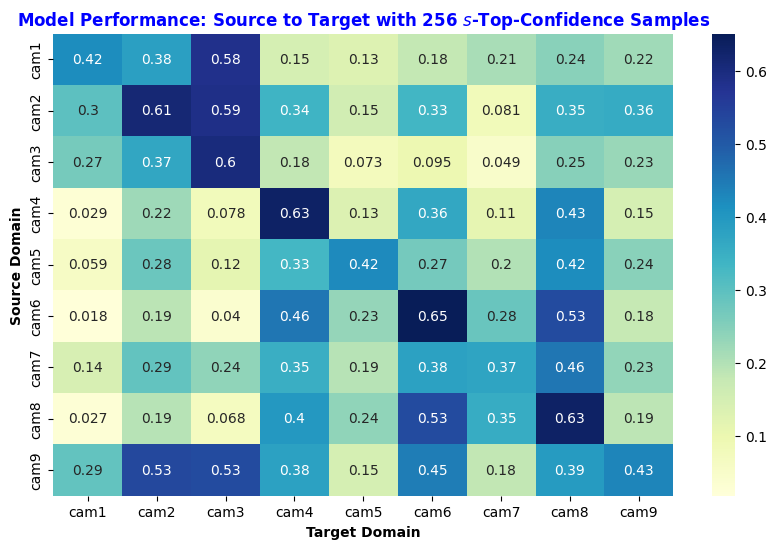

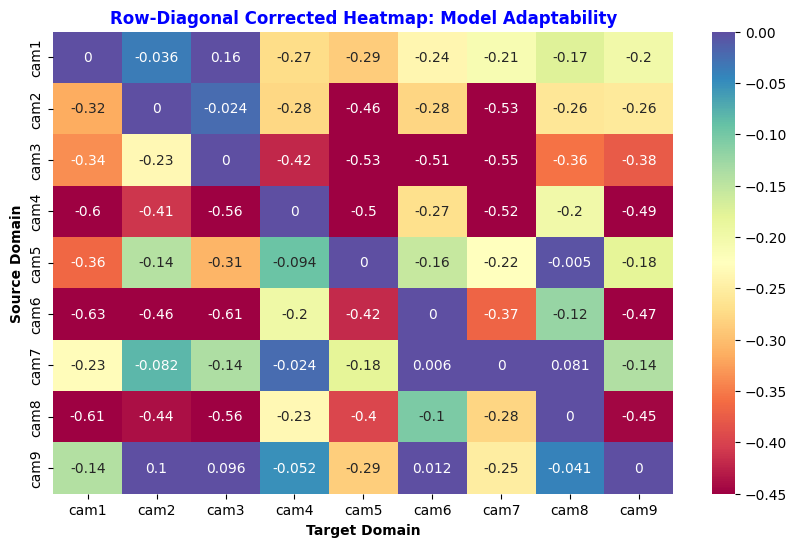

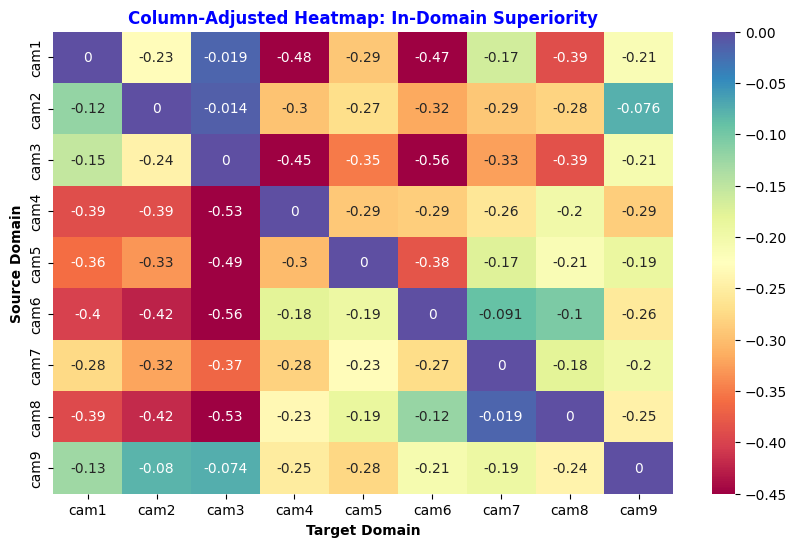

In [37]:
pivot_sb, pivot_sb_row_adj, pivot_sb_col_adj = plot_heatmap(df_stream, 
                                                            samples=[256], 
                                                            strategies=['thresholded-top-confidence-max'],
                                                            dom_periods=restricted_dom_periods)

<h2> <font color="blue"> 2.2 Hiearchichal Clustering </font><h2>


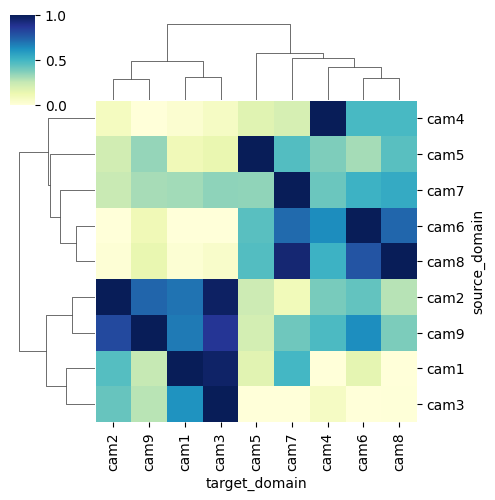

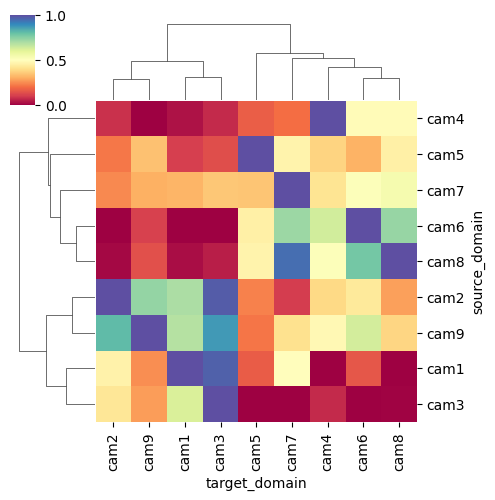

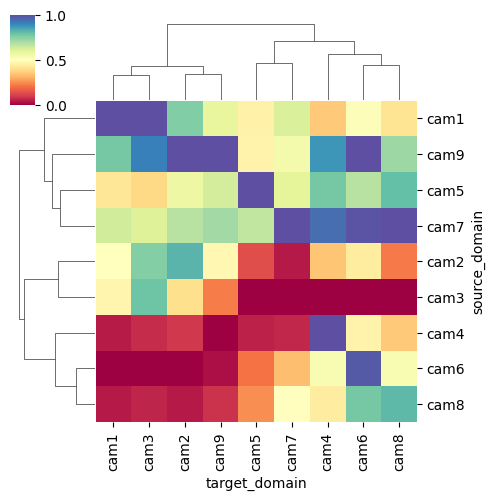

In [12]:
# Create the clustermap plots
grid_sb = sns.clustermap(pivot_sb, cmap='YlGnBu', standard_scale=1, figsize=(5, 5))

grid_sb.fig.savefig("E:\Download\images-journal\clustermap.pdf", dpi=300)

grid_sb_col_adj= sns.clustermap(pivot_sb_col_adj, 
                                      cmap='Spectral', 
                                      standard_scale=1, 
                                      figsize=(5, 5))

grid_sb_row_adj = sns.clustermap(pivot_sb_row_adj, 
                                 cmap='Spectral', 
                                 standard_scale=1, 
                                 figsize=(5, 5))

<h2> <font color="blue"> 2.3 Definition of the clustering </font><h2>

In [14]:
def calculate_clusters(linkage_matrix, min_threshold, max_threshold, step):
    first_occurrences = {}
    seen_clusters = set()

    for threshold in np.arange(min_threshold, max_threshold, step):
        clusters = fcluster(linkage_matrix, threshold, criterion='distance')
        num_clusters = len(np.unique(clusters))
        
        if num_clusters not in seen_clusters:
            seen_clusters.add(num_clusters)
            first_occurrences[num_clusters] = {'threshold': threshold, 'clusters': []}
            
            for cluster_num in range(1, num_clusters + 1):
                indices = np.where(clusters == cluster_num)[0] + 1 # Increment indices by 1
                first_occurrences[num_clusters]['clusters'].append(indices)
    return first_occurrences

In [22]:
# Get the linkage matrix for the rows
row_clusters_sb = calculate_clusters(grid_sb.dendrogram_row.linkage, 0.5, 1.5, 0.05)
row_clusters_sb_adj = calculate_clusters(grid_sb_col_adj.dendrogram_row.linkage, 0.5, 1.5, 0.05)

# Add the third grid
row_clusters_sb_row_adj = calculate_clusters(grid_sb_row_adj.dendrogram_row.linkage, 0.5, 2, 0.05)

# Function to format the threshold with two decimal places
def format_threshold(threshold):
    return "{:.2f}".format(threshold)

# Set the maximum number of num_clusters to display
max_num_clusters_to_display = 6

# Get the sorted unique num_clusters
sorted_num_clusters = sorted(set(row_clusters_sb.keys()).union(set(row_clusters_sb_adj.keys())).union(set(row_clusters_sb_row_adj.keys())))

# Limit the number of num_clusters to display
num_clusters_to_display = sorted_num_clusters[:max_num_clusters_to_display]

# Iterate through clusters and print results side by side for the selected num_clusters
for num_clusters in num_clusters_to_display:
    # Grid 1
    if num_clusters in row_clusters_sb:
        print('Grid 1:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_sb[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_sb[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Grid 1: No clusters found at this threshold.')
        
    print('\t\t\t')

    # Grid 2
    if num_clusters in row_clusters_sb_adj:
        print('Adjusted Grid:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_sb_adj[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_sb_adj[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Adjusted Grid: No clusters found at this threshold.')
    
    print('\t\t\t')

    # Grid 3
    if num_clusters in row_clusters_sb_row_adj:
        print('Row-Adjusted Grid:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_sb_row_adj[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_sb_row_adj[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Row-Adjusted Grid: No clusters found at this threshold.')
    
    print('\n')


Grid 1: No clusters found at this threshold.
			
Adjusted Grid: No clusters found at this threshold.
			
Row-Adjusted Grid:
1 clusters at threshold 1.65:
Cluster 1: [1 2 3 4 5 6 7 8 9]


Grid 1:
2 clusters at threshold 1.15:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]
			
Adjusted Grid:
2 clusters at threshold 1.15:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]
			
Row-Adjusted Grid:
2 clusters at threshold 1.55:
Cluster 1: [1 5 7 9]
Cluster 2: [2 3 4 6 8]


Grid 1:
3 clusters at threshold 1.10:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]
			
Adjusted Grid:
3 clusters at threshold 1.10:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]
			
Row-Adjusted Grid:
3 clusters at threshold 1.15:
Cluster 1: [1 5 7 9]
Cluster 2: [2 3]
Cluster 3: [4 6 8]


Grid 1:
4 clusters at threshold 1.05:
Cluster 1: [5 6 7 8]
Cluster 2: [4]
Cluster 3: [2 9]
Cluster 4: [1 3]
			
Adjusted Grid:
4 clusters at threshold 1.05:
Cluster 1: [5 6 7 8]
Cluster 2: [4]
Cluster 3: [2 9]
Cluster 4: [1 3]

The application of different thresholds leads to a varying number of clusters as follows:

- **Threshold = 1.2:**   
  With this threshold, we get **2 clusters**:
    - **Cluster 1:** Contains cameras 1, 2, 3, and 9
    - **Cluster 2:** Contains cameras 4, 5, 6, 7, and 8

- **Threshold = 1.05:**  
  With this threshold, we get **3 clusters**:
    - **Cluster 1:** Contains cameras 4, 5, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9

- **Threshold = 1:**   
  With this threshold, we get **4 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5

- **Threshold < 1:**  
  With a threshold less than 1, we get **5 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, and 8
    - **Cluster 2:** Contains camera 7
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5
    - **Cluster 5:** Contains cameras 1 and 9

The choice of the threshold should be based on domain knowledge and the specific use case.


1. The analysis shows that both adjusted leads to the same conclusion
2. The definition of the clustering will help us analysing whether with-respect to clustering and training one or several model. 



<h2> <font color="blue"> 2.3 Clustering Performance Analysis </font> </h2>

<h2> UTILS </h2>

In [43]:
def assign_cluster(cam, clusters, dom_periods):
    inclusters=[]
    outclusters=[]
    for cluster in clusters:
        a,b,c,d=process_domains_periods(cluster['source_domain'], cluster['source_period'], dom_periods)
        if(cam in b):
            inclusters.append(cluster)
        else:
            outclusters.append(cluster)
            
    return inclusters,outclusters  

def generate_cameras_pairs(input_string):
    # Find the index of the '-week'
    week_index = input_string.index('-week')

    # Get the cameras and weeks as lists of characters
    cameras = input_string[:week_index].split('o')
    weeks = input_string[week_index+5:].split('o')

    # Add the 'cam' prefix to each camera if not already there
    cameras = ['cam' + cam if not cam.startswith('cam') else cam for cam in cameras]
    weeks = ['week' + week for week in weeks]

    # Check that the number of cameras is equal to the number of weeks
    if len(cameras) != len(weeks):
        raise ValueError("The number of cameras must be equal to the number of weeks")

    # Generate the output
    output = list(zip(cameras, weeks))
    
    return output


def process_domains_periods(source_domain, source_period, eligible_domain_periods):
    joined_string = source_domain + "-" + source_period
    domains_periods = generate_cameras_pairs(joined_string)
    included_domains = [pair[0] for pair in domains_periods]
    excluded_domains_periods = [pair for pair in eligible_domain_periods if pair not in domains_periods]
    excluded_domains = [pair[0] for pair in excluded_domains_periods]
    return domains_periods, included_domains,excluded_domains_periods,excluded_domains


def add_row_to_results(df, data):
    new_row = pd.DataFrame([data])
    return pd.concat([df, new_row], ignore_index=True)

def test_strategies(number_cluster,
                    cluster_content, 
                    selected_sample_sizes,
                    selected_strategy,
                    selected_source_domain_multi,
                    selected_source_period_multi,
                    restricted_eligible_clustering_df,
                    df_multistream,
                    excluded_domains_df,
                    included_target_domains,
                    excluded_target_domains):
    
    results = pd.DataFrame()
    
    for sample_size in selected_sample_sizes:
        for strategy in selected_strategy:
            
            #IN CLUSTER COMPUTATION 
            one_strategy_one_sample_df, mean_self,_ = filter_df(restricted_eligible_clustering_df, 
                                                                 strategies=[strategy], 
                                                                 samples=[sample_size])
            
            filtered_df_multistream, mean_multi,_ = filter_df(df_multistream, 
                                                               strategies=[strategy], 
                                                               samples= [sample_size], 
                                                               source_periods=[selected_source_period_multi], 
                                                               source_domains=[selected_source_domain_multi], 
                                                               excluded_domains=[excluded_target_domains])
            
            stats_in= perform_statistical_tests(one_strategy_one_sample_df, filtered_df_multistream,'single-stream','multi-stream')
            
            #OUT CLUSTER COMPUTATION
            one_strategy_one_sample_df_out,mean_self_out,c = filter_df(excluded_domains_df,
                                                                         strategies = [strategy], 
                                                                         samples=[sample_size])
            
            filtered_df_multistream_out,mean_multi_out,c = filter_df(df_multistream,
                                                                       strategies=[strategy], 
                                                                       samples=[sample_size], 
                                                                       source_periods=[selected_source_period_multi], 
                                                                       source_domains=[selected_source_domain_multi], 
                                                                       excluded_domains=included_target_domains)

            stats_out = perform_statistical_tests(one_strategy_one_sample_df_out, 
                                                  filtered_df_multistream_out,
                                                  'single-stream',
                                                  'multi-stream','excl')
            
            data = {'samples': sample_size, 
                    'strategy': strategy, 
                    'mean self': mean_self,
                    'mean multi': mean_multi,
                    'cluster numbers': number_cluster,
                    'cameras': cluster_content,
                    **stats_in,
                    'mean self_out': mean_self,
                    'mean multi_out': mean_multi_out,
                    **stats_out}
            results = add_row_to_results(results, data)
        
    return results



def analyze_performance(number_cluster, 
                        selected_strategy,
                        sample_sizes,
                        source_domain, 
                        source_period,
                        eligible_clustering_domain_periods,
                        df_stream,
                        df_multistream):
    
    sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
    
    domain_periods, included_domains, excluded_domains_periods, excluded_domains = process_domains_periods(source_domain,source_period, eligible_clustering_domain_periods)
    
    included_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=domain_periods)
    
    excluded_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=excluded_domains_periods)
    
    cluster_cameras = ", ".join([cam for cam, _ in domain_periods])
    
    #print('Number of records:', len(restricted_eligible_clustering_df))
    #print('Mean mAP50-95:', restricted_eligible_clustering_df['mAP50-95'].mean())

    results_df = test_strategies(number_cluster,
                                 cluster_cameras,
                                 sample_sizes,
                                 selected_strategy,
                                 source_domain,
                                 source_period,
                                 included_domains_df,
                                 df_multistream,
                                 excluded_domains_df,
                                 included_domains,
                                 excluded_domains)
    
    return results_df

In [52]:
# Define clusters
clusters = [
    {
        'number': 1,
        'source_domain': 'cam1o2o3o4o5o6o7o8o9',
        'source_period': 'week1o1o5o2o3o4o4o3o1'
    },
    {
        'number': 2,
        'source_domain': 'cam1o2o3o9',
        'source_period': 'week1o1o5o1'
    },
    {
        'number': 2,
        'source_domain': 'cam4o5o6o7o8',
        'source_period': 'week2o3o4o4o3'
    },
    {
        'number': 3,
        'source_domain': 'cam4o5o6o7o8',
        'source_period': 'week2o3o4o4o3'
    },
    {
        'number': 3,
        'source_domain': 'cam1o3',
        'source_period': 'week1o5'
    },
    
    {
      'number': 3,
       'source_domain': 'cam2o9',
        'source_period': 'week1o1'
    },
    
#    {
  #      'number': 4,
 #       'source_domain': 'cam5o6o7o8',
     #   'source_period': 'week3o4o4o3'
  #  },
     # {
  #        'number': 4,
       #   'source_domain': 'cam1o3',
         # 'source_period': 'week1o5'
    #  },
    
     # {
    #    'number': 4,
        # 'source_domain': 'cam2o9',
         # 'source_period': 'week1o1'
     # },
     # {
       # 'number': 4,
       #  'source_domain': 'cam4',
         # 'source_period': 'week2'
     # },
    {
        'number': 5,
        'source_domain': 'cam6o7o8',
        'source_period': 'week4o4o3'
    },
    {
        'number': 5,
        'source_domain': 'cam1o3',
        'source_period': 'week1o5'
    },
    
    {
      'number': 5,
       'source_domain': 'cam2o9',
        'source_period': 'week1o1'
    },
    {
      'number': 5,
       'source_domain': 'cam4',
        'source_period': 'week2'
    },
    {
      'number': 5,
       'source_domain': 'cam5',
        'source_period': 'week3'
    },
]

<h2> <font color="blue"> 3.2 Performance analysis of 2 cluster - CLUSTER of CAMERAS 1,2,3 and 9 </font> </h2>

In [45]:
# Define the column names to display
selected_strategy =['n-first','uniform-random-0','thresholded-top-confidence-max']
selected_sample_sizes= [96,216]

display_columns = ['cluster numbers', 'cameras', 'mean self', 'mean multi', 'T-test result']


def highlight_rows(s):
    styles = [''] * len(s)
    for i, (mean_multi, mean_single) in enumerate(zip(s['mean multi'], s['mean self'])):
        if mean_multi > mean_single:
            styles[i] = 'color: red'
    return styles

# Now, loop over unique strategies and sample sizes
for strategy in selected_strategy:
    for sample in selected_sample_sizes:
        strategy_sample_df = final_results_df[(final_results_df['strategy'] == strategy) 
                                              & (final_results_df['samples'] == sample)]
        
        # If DataFrame is not empty, display it
        if not strategy_sample_df.empty:
            # Print title in blue with HTML tags
            display(HTML(f"<h2 style='color:blue;'><b>Strategy: {strategy}, Sample Size: {sample}</b></h2>"))
            
            # Note: use pd.set_option to format all floats to 3 decimal places
            with pd.option_context('display.float_format', '{:.3f}'.format): 
                df_to_display = strategy_sample_df[display_columns].reset_index(drop=True)
                
                # Apply row highlighter
                df_to_display.style.apply(highlight_rows, axis=1)
                
                # Display the DataFrame
                display(df_to_display)
        else:
            print(f"No data available for strategy {strategy} and sample size {sample}")


NameError: name 'final_results_df' is not defined

<h2> UTILS </h2>

In [94]:
def total_samples_cluster(cam_week_tuples, strategy, samples, df, dom_periods):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data1={}
        
        cam, week = cam_week_tuple
        data1["target_domain"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters,dom_periods)
        # Loop over each sample
        for sample in samples:
            data1["samples"]=sample*9
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample],
                                        students=['yolov8n'])
            data1["strategy"]= '9-models'
            data1["mAP50-95"]=mean_cam_self
            result_df = pd.concat([result_df, pd.DataFrame([data1])], ignore_index=True)

            for cls in inclusters:
                data2={}
                data2["target_domain"]=cam
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam],
                                           students=['yolov8n'])
                data2[f"samples"]=number_of_samples*9/len(in_cameras)
                data2[f"strategy"]=f"{cls['number']}-models"
                data2["mAP50-95"] = cluster_mean
                data2[f"smpls cls_{cls['number']}"]=number_of_samples
                data2[f"cam cls_{cls['number']}"]=b
                
                result_df = pd.concat([result_df, pd.DataFrame([data2])], ignore_index=True)
        
    return result_df

<h2> <font color="blue"> 3.1. Centralized Stream-Based setting   </font> </h2>

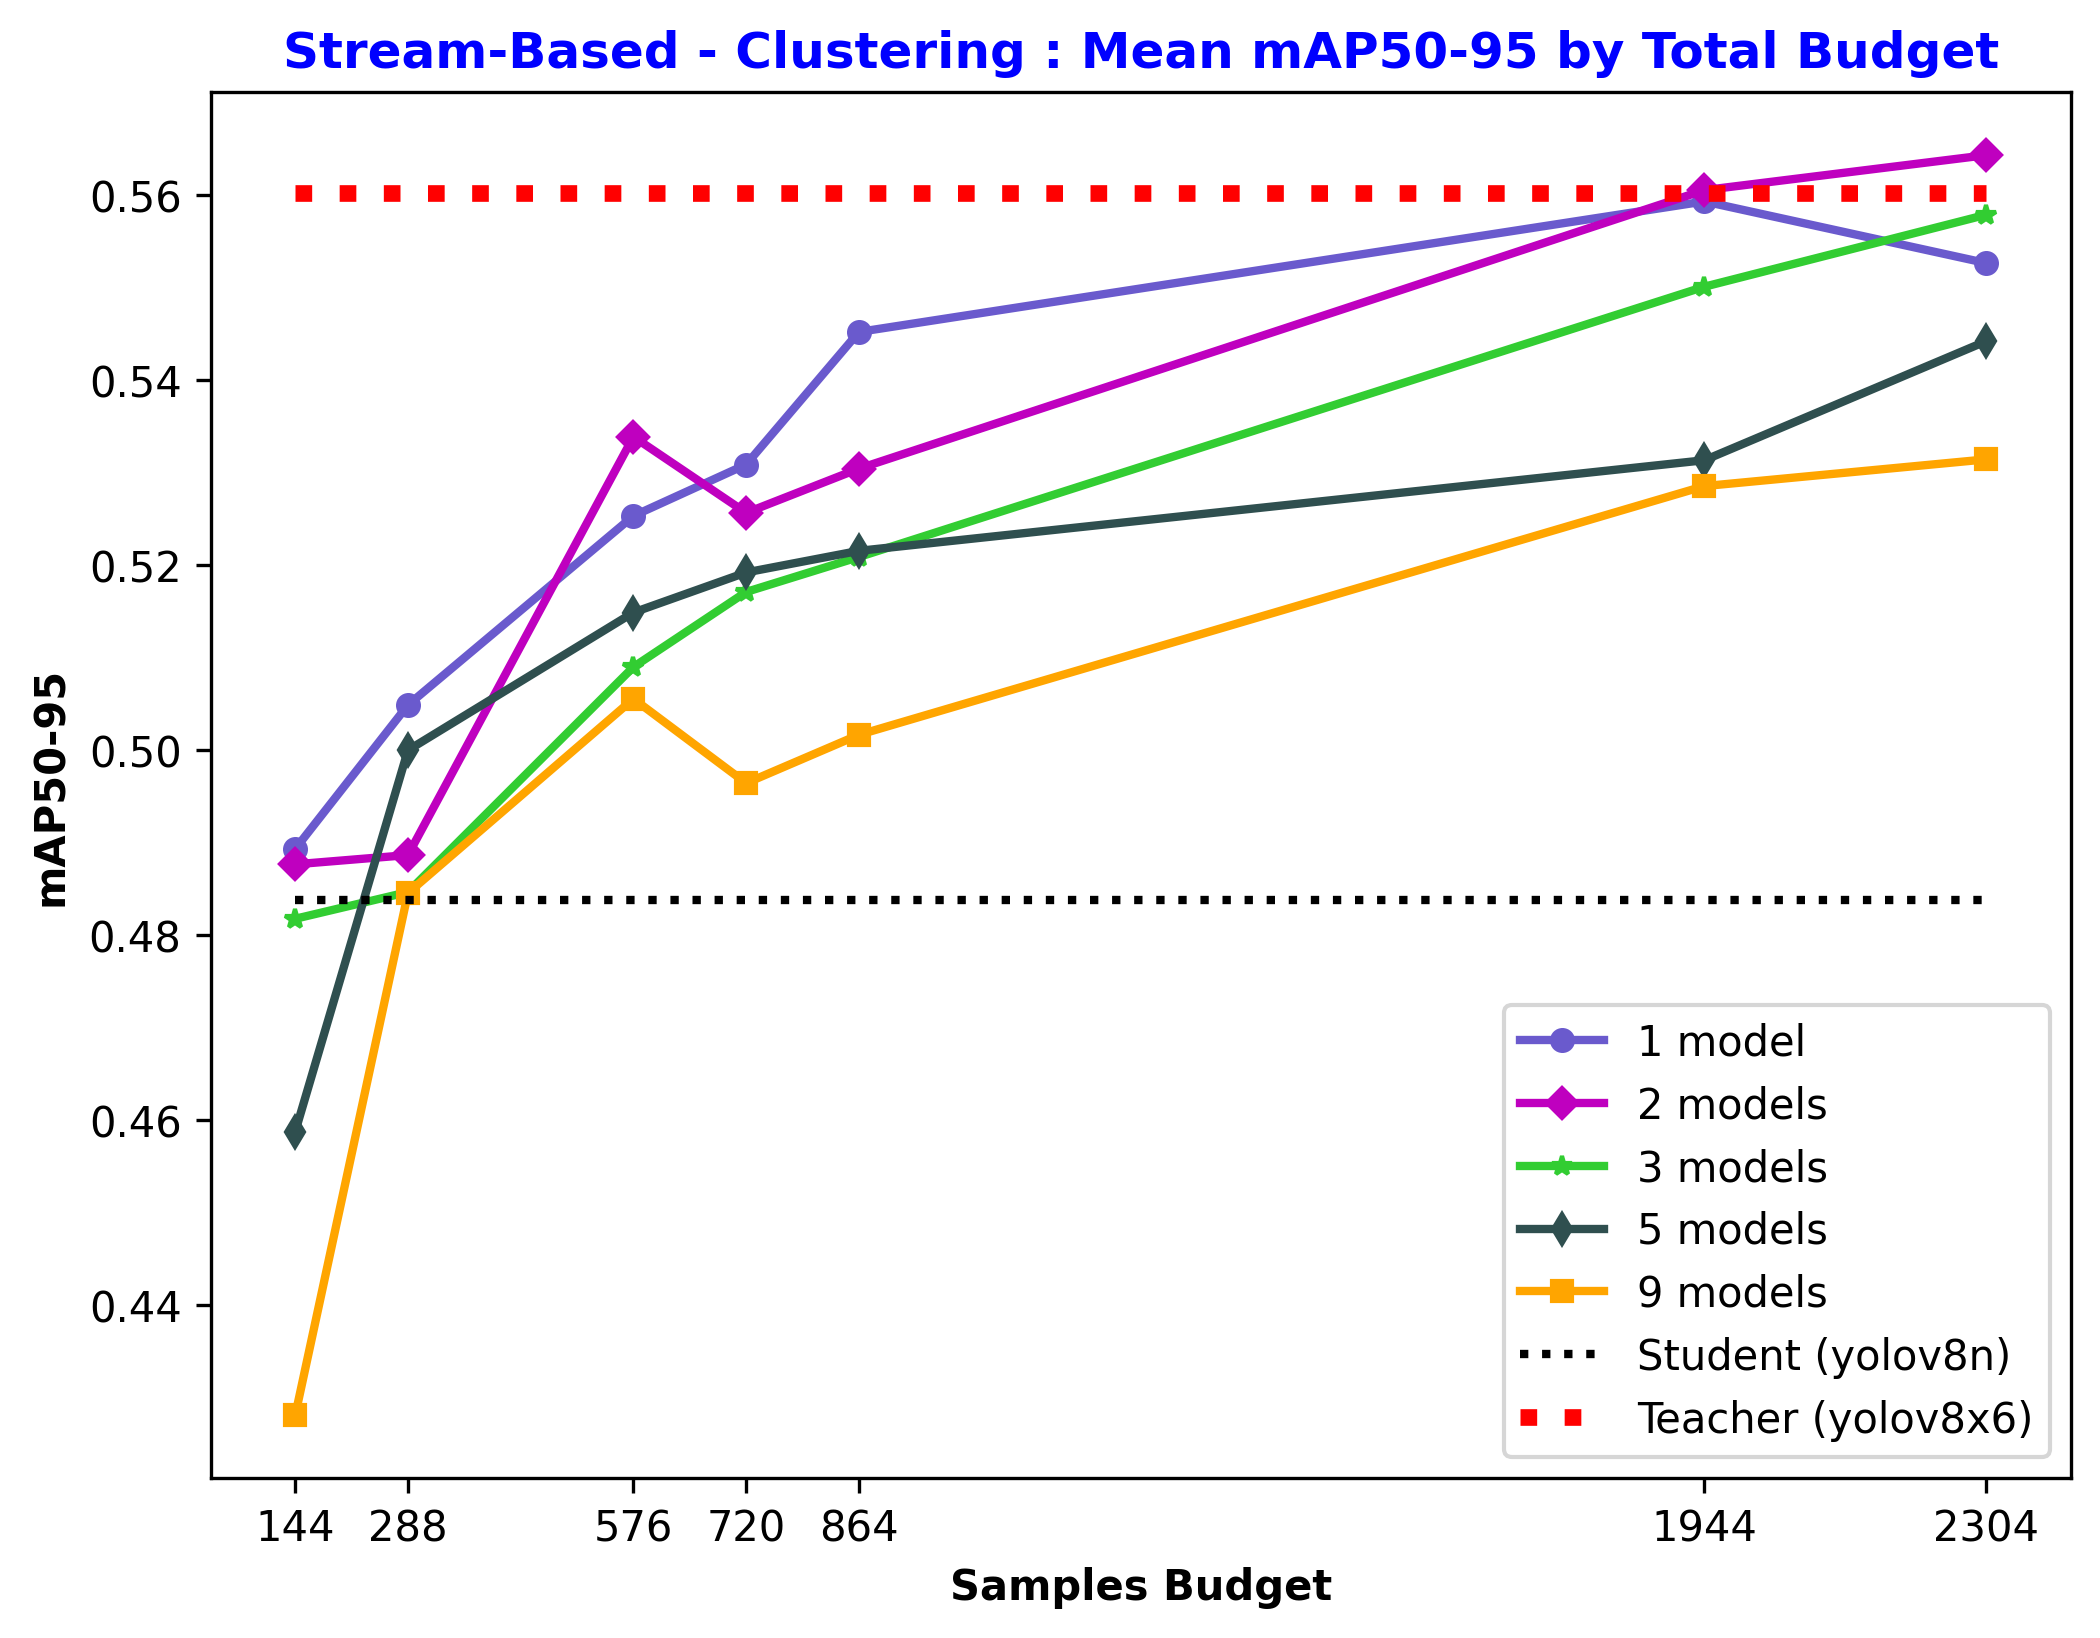

,mean_1-models,mean_2-models,mean_3-models,mean_5-models,mean_9-models,std_1-models,std_2-models,std_3-models,std_5-models,std_9-models,count_1-models,count_2-models,count_3-models,count_5-models,count_9-models
samples,,,,,,,,,,,,,,,
144.000,0.489,0.488,0.482,0.459,0.428,0.121,0.111,0.115,0.124,0.122,9,9,9,9,9
288.000,0.505,0.489,0.485,0.500,0.485,0.121,0.122,0.121,0.106,0.108,9,9,9,9,9
576.000,0.525,0.534,0.509,0.515,0.506,0.119,0.118,0.115,0.098,0.096,9,9,9,9,9
720.000,0.531,0.526,0.517,0.519,0.496,0.111,0.115,0.115,0.109,0.106,9,9,9,9,9
864.000,0.545,0.530,0.521,0.522,0.502,0.122,0.113,0.118,0.116,0.113,9,9,9,9,9
1944.000,0.559,0.561,0.550,0.531,0.529,0.105,0.107,0.112,0.115,0.102,9,9,9,9,9
2304.000,0.553,0.564,0.558,0.544,0.531,0.107,0.108,0.108,0.106,0.115,9,9,9,9,9


In [103]:
samples_sb = [16,32,64,80,96,216,256]   # replace with your samples
df_clustering_sb = total_samples_cluster(restricted_dom_periods, 
                                         'thresholded-top-confidence-max', 
                                         samples_small, df_all, restricted_dom_periods)

total_samples_sb = [x * 9 for x in samples_sb]
cluster_strategy_styles = {
    '1-models': {'color': 'slateblue', 'marker': 'o','label':'1 model'},
    '2-models': {'color': 'm', 'marker': 'D','label':'2 models'},
    '3-models': {'color': 'limegreen', 'marker': '*','label':'3 models'},
    '5-models': {'color': 'darkslategray', 'marker': 'd','label':'5 models'},
    '9-models': {'color': 'orange', 'marker': 's','label':'9 models'},
}
plot_style={
    'tick_positions' : total_samples_sb,
    'tick_labels':[str(value) for value in total_samples_sb],
    'title': 'Stream-Based - Clustering : Mean mAP50-95 by Total Budget',
    'setGrid': False,
    'filename':"E:\Download\images-journal\clusteringstream-based.pdf"
}

benchmark_strategies_plot(df_clustering_streambased, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

result_df_cluster_sb = compute_pivot_tables(df_clustering_streambased)
display(result_df_cluster_sb)

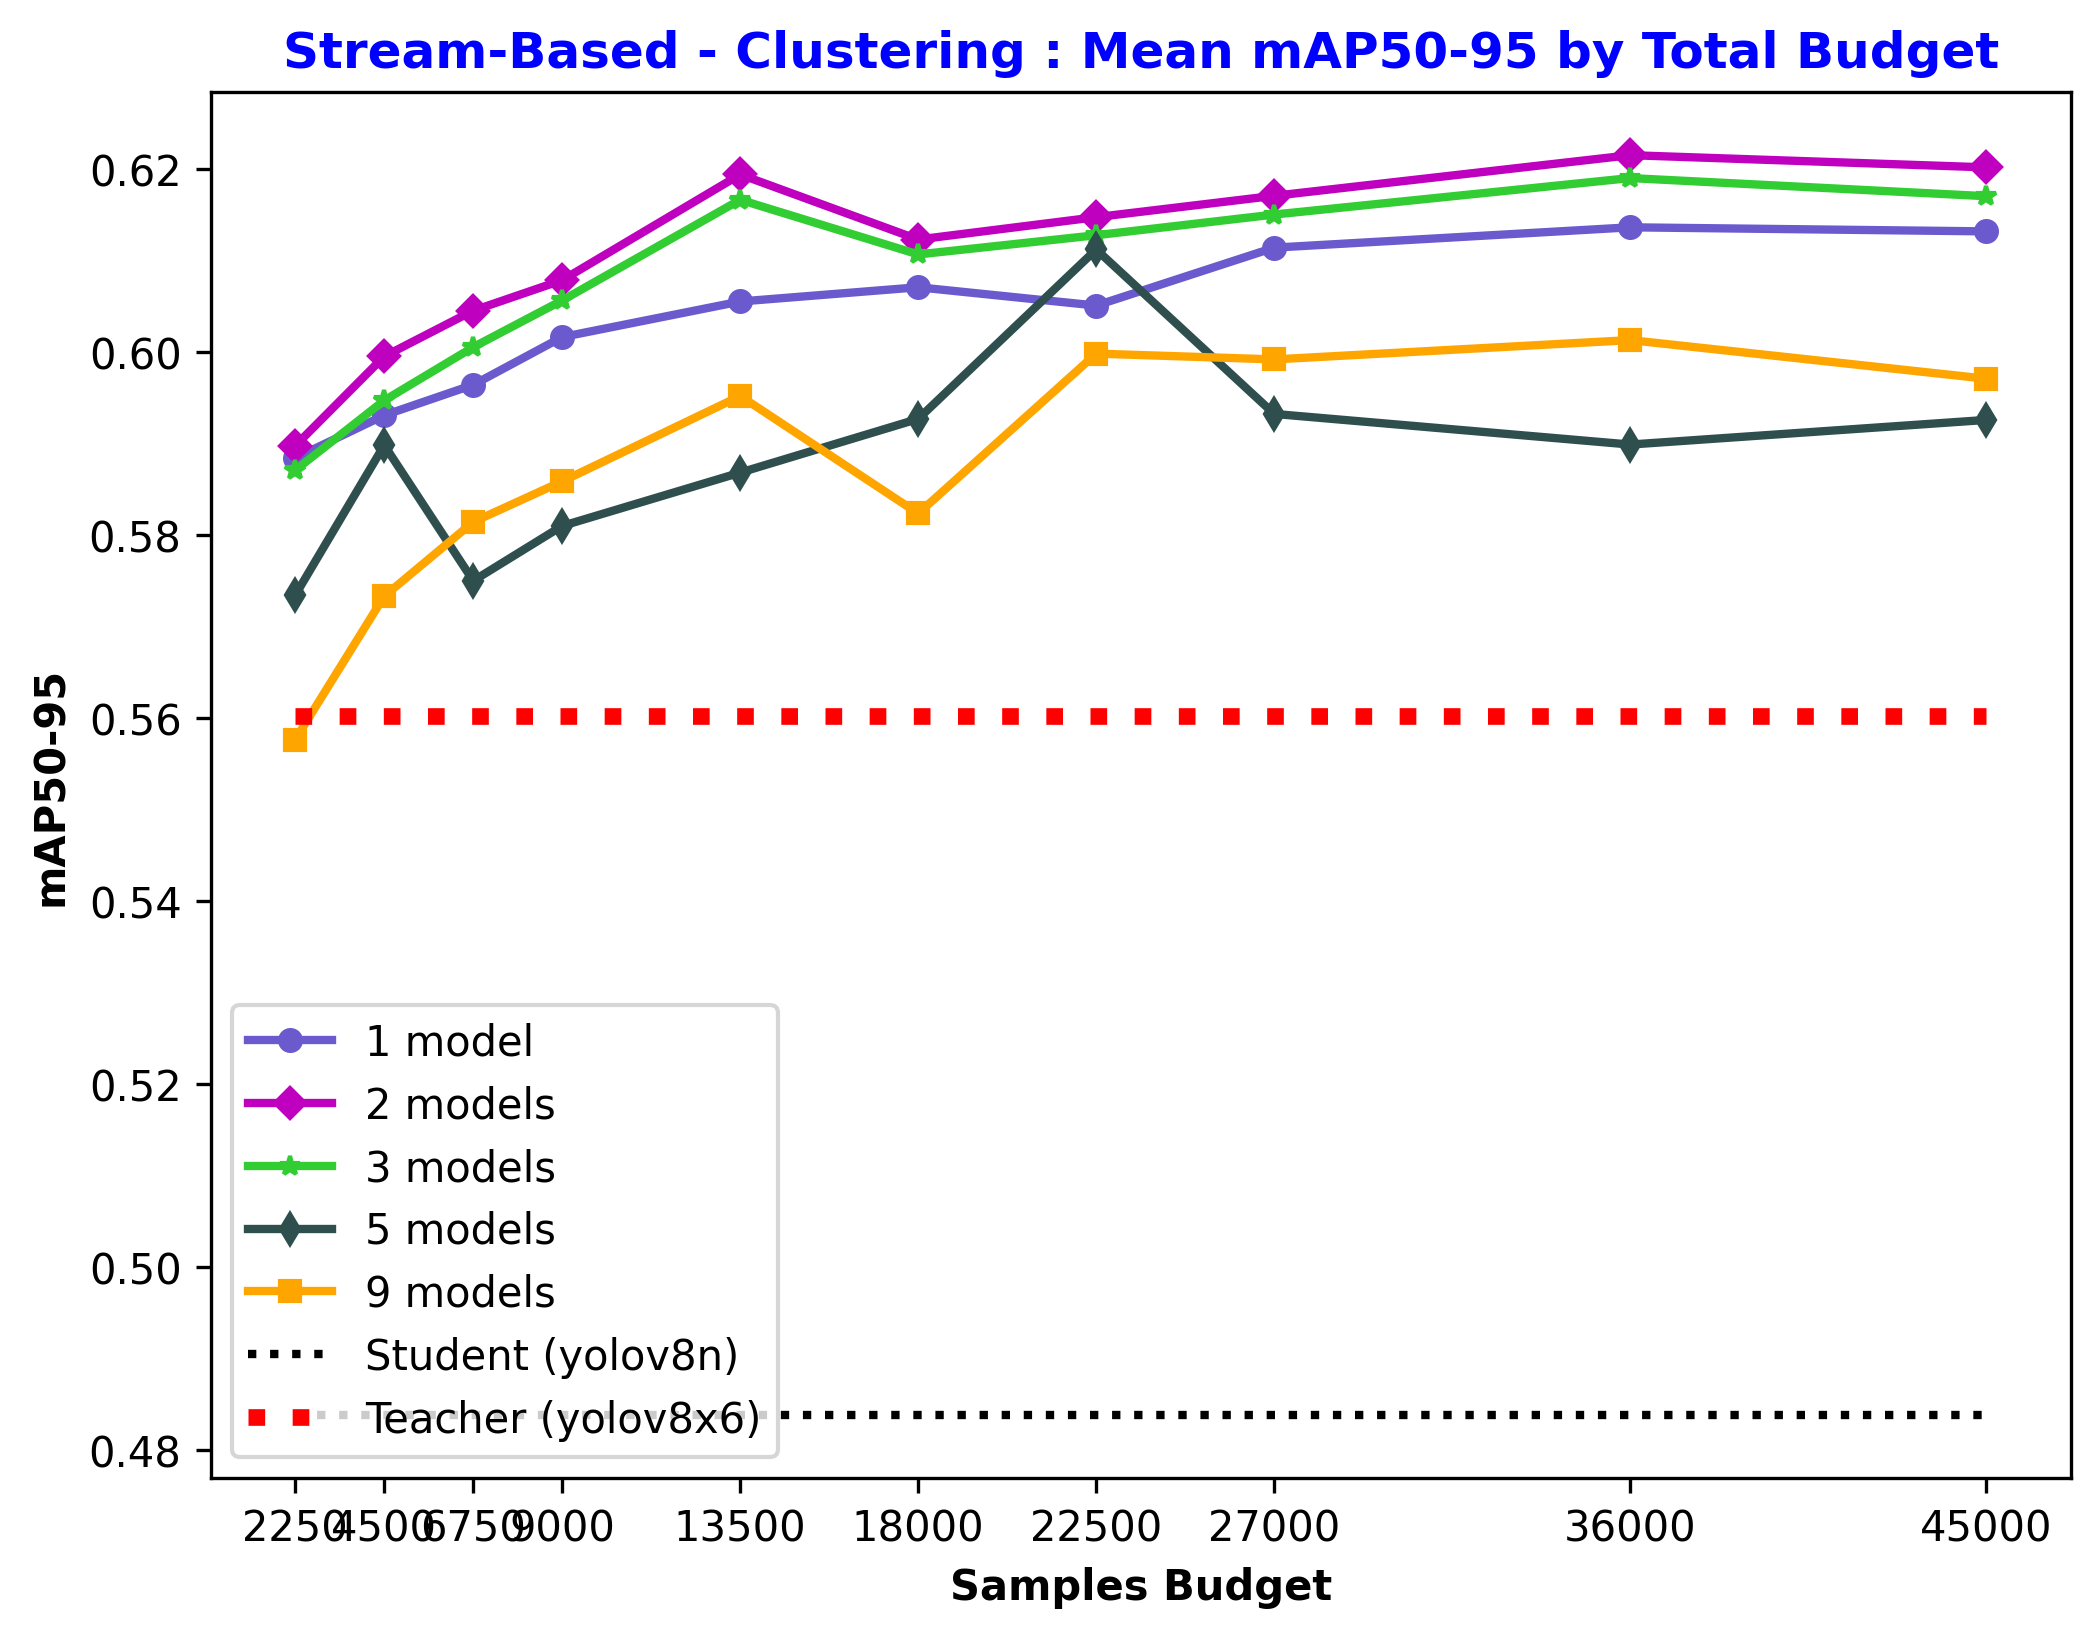

,mean_1-models,mean_2-models,mean_3-models,mean_5-models,mean_9-models,std_1-models,std_2-models,std_3-models,std_5-models,std_9-models,count_1-models,count_2-models,count_3-models,count_5-models,count_9-models
samples,,,,,,,,,,,,,,,
2250.000,0.588,0.590,0.587,0.573,0.558,0.097,0.091,0.092,0.099,0.100,9,9,9,9,9
4500.000,0.593,0.600,0.595,0.590,0.573,0.100,0.093,0.096,0.096,0.096,9,9,9,9,9
6750.000,0.596,0.605,0.601,0.575,0.581,0.101,0.092,0.094,0.095,0.095,9,9,9,6,9
9000.000,0.602,0.608,0.606,0.581,0.586,0.097,0.095,0.097,0.096,0.096,9,9,9,6,9
13500.000,0.606,0.619,0.617,0.587,0.595,0.094,0.091,0.090,0.094,0.092,9,9,9,6,9
18000.000,0.607,0.612,0.611,0.593,0.582,0.097,0.095,0.095,0.095,0.093,9,9,9,6,8
22500.000,0.605,0.615,0.613,0.611,0.600,0.103,0.093,0.093,0.091,0.094,9,9,9,5,7
27000.000,0.611,0.617,0.615,0.593,0.599,0.097,0.089,0.088,0.092,0.099,9,9,9,6,9
36000.000,0.614,0.622,0.619,0.590,0.601,0.096,0.094,0.093,0.098,0.094,9,9,9,6,9


In [102]:
df_clustering_largesb = total_samples_cluster(restricted_dom_periods, 
                                         'thresholded09160-top-confidence-max', 
                                         samples_large, df_all, restricted_dom_periods)

total_samples_sb = [x * 9 for x in samples_large]
cluster_strategy_styles = {
    '1-models': {'color': 'slateblue', 'marker': 'o','label':'1 model'},
    '2-models': {'color': 'm', 'marker': 'D','label':'2 models'},
    '3-models': {'color': 'limegreen', 'marker': '*','label':'3 models'},
    '5-models': {'color': 'darkslategray', 'marker': 'd','label':'5 models'},
    '9-models': {'color': 'orange', 'marker': 's','label':'9 models'},
}
plot_style={
    'tick_positions' : total_samples_sb,
    'tick_labels':[str(value) for value in total_samples_sb],
    'title': 'Stream-Based - Clustering : Mean mAP50-95 by Total Budget',
    'setGrid': False,
    'filename':"E:\Download\images-journal\clusteringstream-based.pdf"
}

benchmark_strategies_plot(df_clustering_largesb, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

result_df_cluster_largesb = compute_pivot_tables(df_clustering_largesb)
display(result_df_cluster_largesb)

In [ ]:
samples_sb = [16,32,64,80,96,216,256]   # replace with your samples
df_clustering_sb = total_samples_cluster(restricted_dom_periods, 
                                         'thresholded-top-confidence-max', 
                                         samples_small, df_all, restricted_dom_periods)

total_samples_sb = [x * 9 for x in samples_sb]
cluster_strategy_styles = {
    '1-models': {'color': 'slateblue', 'marker': 'o','label':'1 model'},
    '2-models': {'color': 'm', 'marker': 'D','label':'2 models'},
    '3-models': {'color': 'limegreen', 'marker': '*','label':'3 models'},
    '5-models': {'color': 'darkslategray', 'marker': 'd','label':'5 models'},
    '9-models': {'color': 'orange', 'marker': 's','label':'9 models'},
}
plot_style={
    'tick_positions' : total_samples_sb,
    'tick_labels':[str(value) for value in total_samples_sb],
    'title': 'Stream-Based - Clustering : Mean mAP50-95 by Total Budget',
    'setGrid': False,
    'filename':"E:\Download\images-journal\clusteringstream-based.pdf"
}

benchmark_strategies_plot(df_clustering_streambased, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)

result_df_cluster_sb = compute_pivot_tables(df_clustering_streambased)
display(result_df_cluster_sb)

We consider a scenario with bandwith and memory constraint such as there is no possibility to transmit the images. The sampling has to be done on the fly. The section analyses the performance of training models based on clusters. The analysis is done based on a total budget constraint. Otherwise, the models received a Budget B and decides to train M models by associating to each image a cluster _m_. 

The analysis of the graph shows that clustering has benefits in comparison of scene-specific training. The analysis shows as well that at low sample number the  

The analysis shows that 

In this scenario we consider a setting where the local transmission is limited forcing to select a limited sample 
The analysis shows that if you have access to multiple cameras and that the labelling is not an issue, there is no interest to specialized on a single domain. WE HAVE TO PLOT A GRAPH with TOTAL BUDGET 1 model per camera vs 1 model for all the cameras. TOTAL BUDGET. It should display:

We should do the following run : 
[144, 288, 432, 576, 720, 864, 1152, 1944, 2304] 1-cluster
[                                              ] 2 models

Of course this works better but one should be careful that it's not the effect of the strategy that is not maximizing. Indeed, one can easily argue that 

Clustering conclusion : 

1. One model from all the source_domain is better than sub-domain. Clustering does not provide a competitive advantage. 

2. We also lose in generalizability without performance compensentation as clustering. 

<h1> <font color="blue"> 4. POOL-BASED AND SAMPLE BASED SCENARIOS </font><h1>

<h2> <font color="blue"> 4.1 STRATEGIES-PLOT </font><h2>

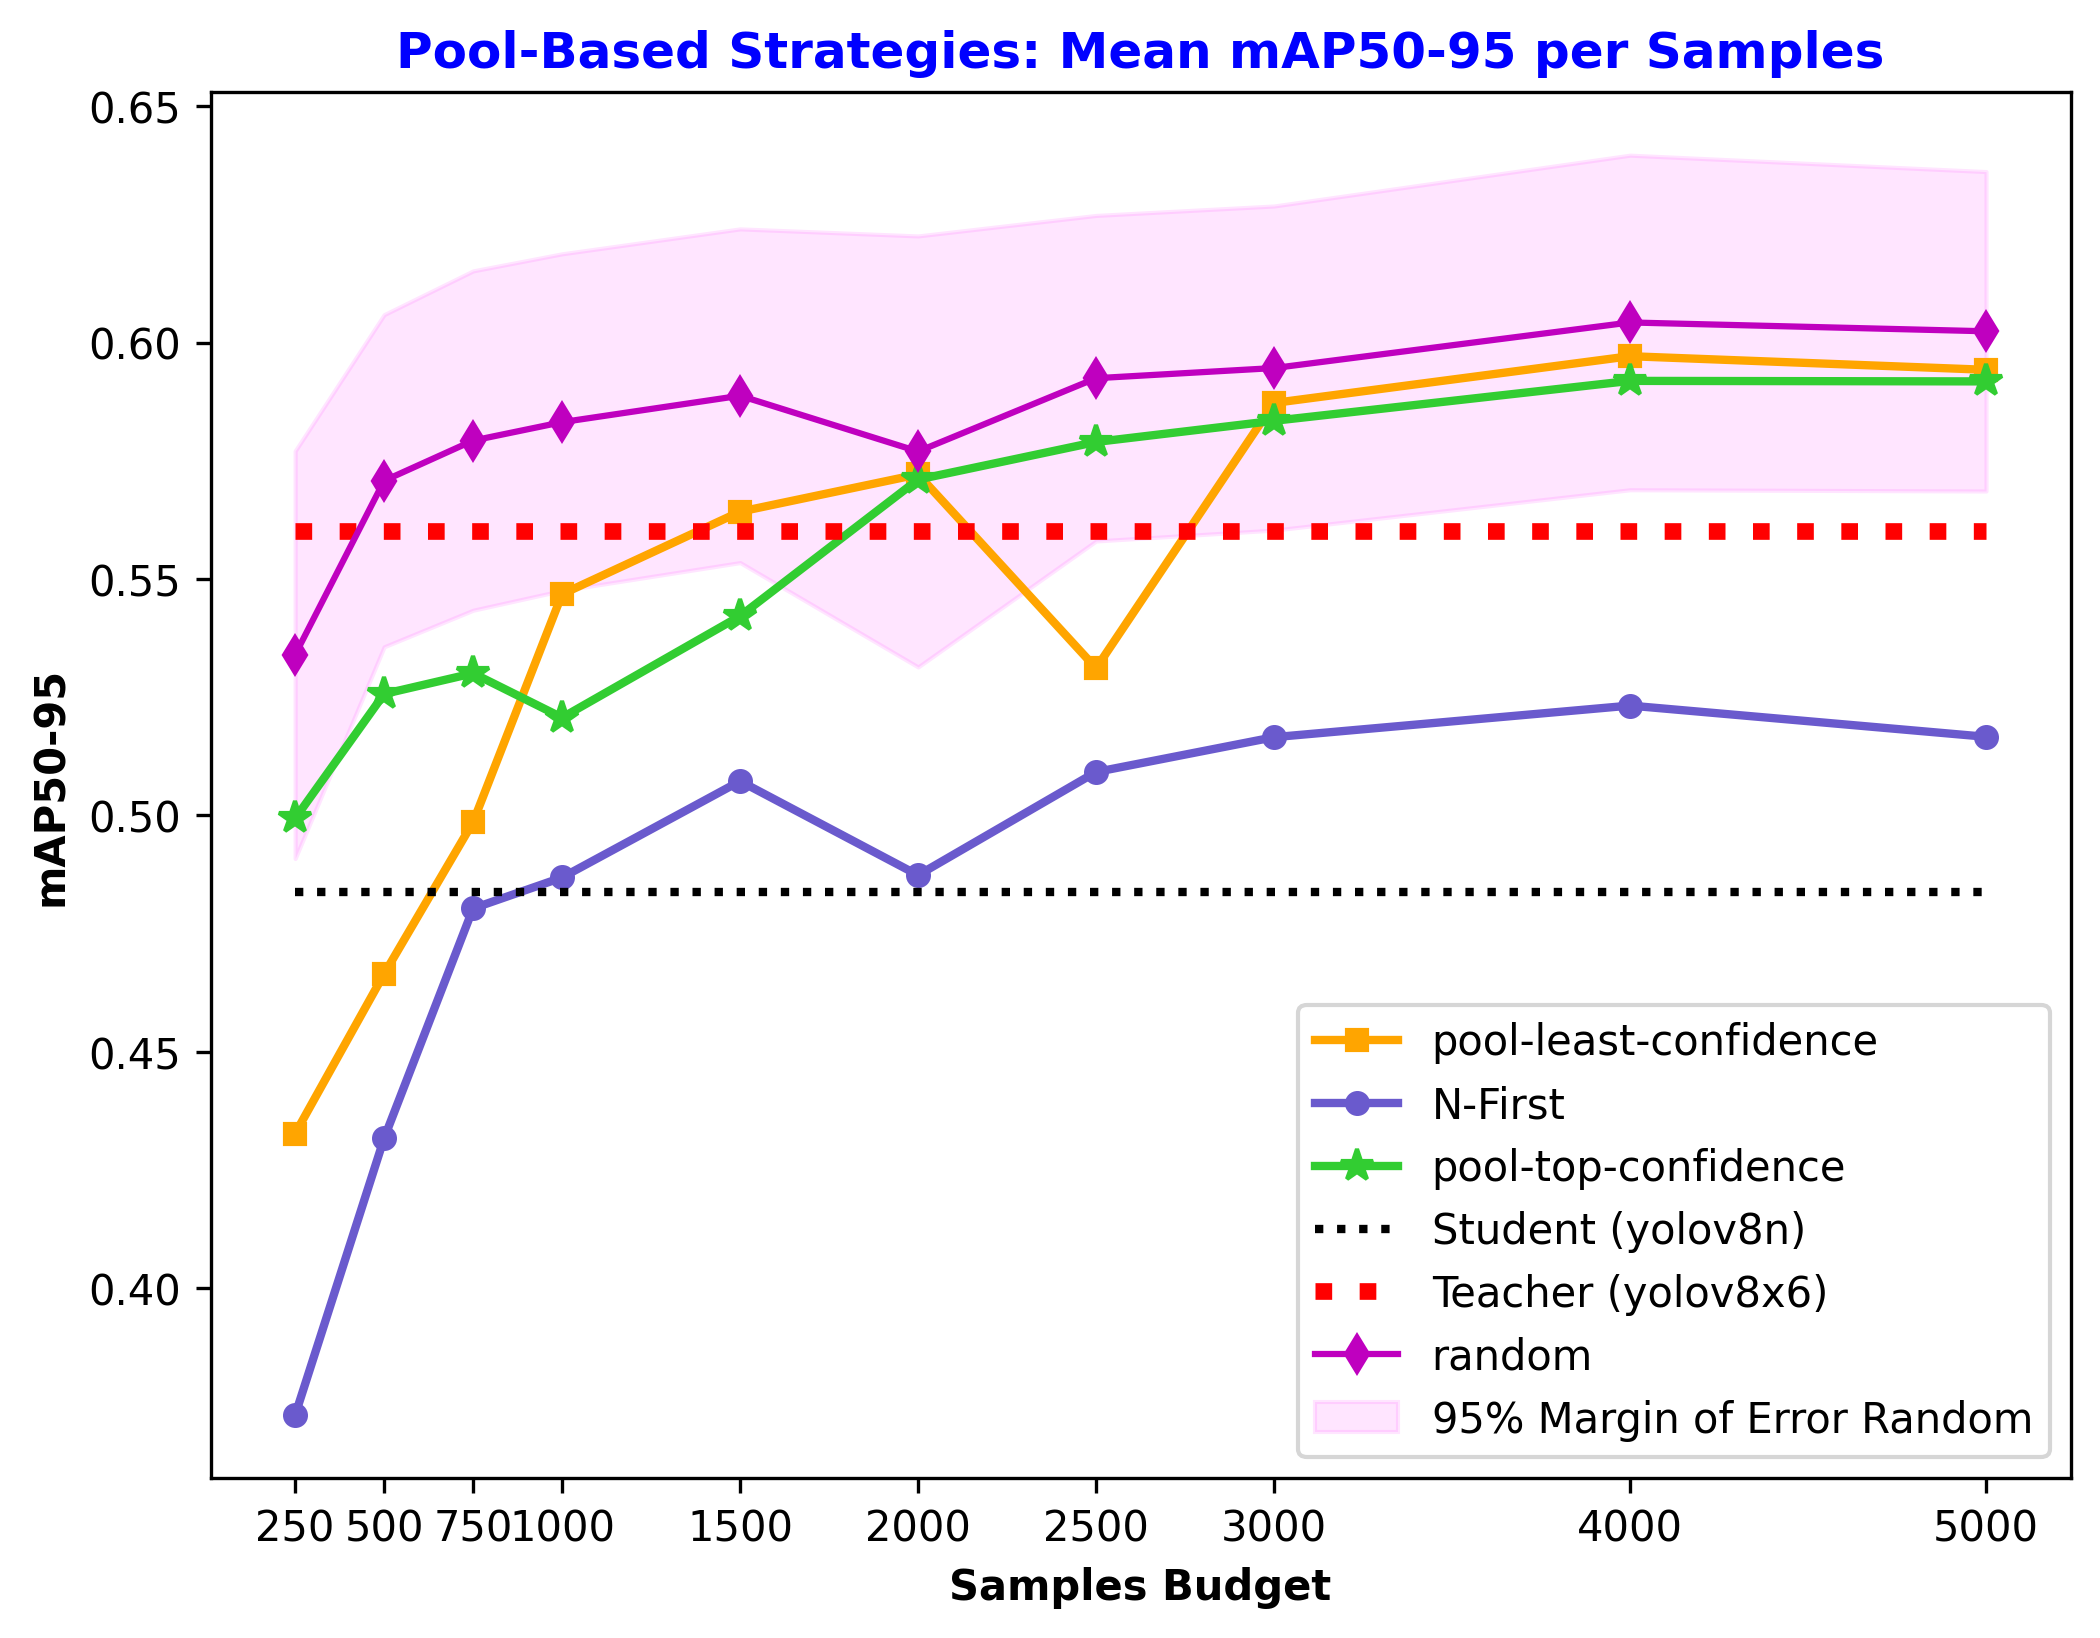

,mean_least-confidence-max,mean_n-first,mean_top-confidence-max,std_least-confidence-max,std_n-first,std_top-confidence-max,count_least-confidence-max,count_n-first,count_top-confidence-max
samples,,,,,,,,,
250,0.433,0.373,0.499,0.094,0.168,0.104,9,9,9
500,0.466,0.432,0.526,0.151,0.146,0.102,9,9,9
750,0.499,0.480,0.530,0.113,0.134,0.107,9,9,9
1000,0.547,0.487,0.521,0.102,0.136,0.130,9,9,9
1500,0.564,0.507,0.542,0.108,0.136,0.111,9,9,9
2000,0.572,0.487,0.571,0.101,0.198,0.099,9,9,9
2500,0.531,0.509,0.579,0.157,0.159,0.093,9,9,9
3000,0.587,0.517,0.583,0.100,0.197,0.095,9,10,9
4000,0.597,0.523,0.592,0.100,0.180,0.096,9,9,9


In [104]:
pool_strategies = ['n-first', 'least-confidence-max', 'top-confidence-max']

df_random_pb, _ , _ = filter_df(df_all,
                                       same_domain=True,
                                       samples=samples_large,
                                       dom_periods=restricted_dom_periods,
                                       prefix_random=prefix_random_pb)

df_same_domain_restricted_pb, _ , _ = filter_df(df_all,
                                               same_domain=True,
                                               strategies=pool_strategies,
                                               samples=samples_large,
                                               dom_periods=restricted_dom_periods) 

strategy_styles = {
    'n-first': {'color': 'slateblue', 'marker': 'o','label':'N-First'},
    'top-confidence-max': {'color': 'limegreen', 'marker': '*','label':'pool-top-confidence','markersize':8},
    'least-confidence-max': {'color': 'orange', 'marker': 's','label':'pool-least-confidence'},
}


plot_style={
    'tick_positions' : samples_large,
    'tick_labels':[str(value) for value in samples_large],
    'title': 'Pool-Based Strategies: Mean mAP50-95 per Samples',
    'setGrid': False,
    'filename':"E:\Download\images-journal\pbstrategies.pdf",
}


benchmark_strategies_plot(df_same_domain_restricted_pb, 
                          strategy_styles=strategy_styles,
                          plot_style=plot_style,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          random_df=df_random_pb,
                          prefix_random=prefix_random_pb)


result_df_pb = compute_pivot_tables(df_same_domain_restricted_pb)
display(result_df_pb)

<h2> <font color="blue"> 4.2 Heatmap </font><h2>

In [105]:
df_clustering_pb,_,_ = filter_df(df_all,
                               strategies=['top-confidence-max'],
                               dom_periods=restricted_dom_periods,
                               samples=[4000])

df_pivot_pb, df_pivot_rowadj_pb, df_pivot_coladj_pb = plot_heatmap(df_clustering_pb, samples=[4000])

grid_pb = sns.clustermap(df_pivot_pb, cmap='YlGnBu', standard_scale=1, figsize=(5, 5))

grid_coladj_pb = sns.clustermap(df_pivot_coladj_pb, cmap='YlGnBu', standard_scale=1, figsize=(5, 5))


# Get the linkage matrix for the rows
row_linkage_pb = grid_pb.dendrogram_row.linkage
row_clusters_pb = calculate_clusters(row_linkage_pb, 0.5, 1.5, 0.05)

row_linkage_adjusted_pb = grid_column_adjusted_pb.dendrogram_row.linkage
row_clusters_adjusted_pb = calculate_clusters(row_linkage_adjusted_pb, 0.5, 1.5, 0.05)

# Get the sorted unique num_clusters
sorted_num_clusters_pb = sorted(set(row_clusters_pb.keys()).union(set(row_clusters_adjusted_pb.keys())))

# Limit the number of num_clusters to display
num_clusters_to_display_pb = sorted_num_clusters_pb[:max_num_clusters_to_display]

# Iterate through clusters and print results side by side for the selected num_clusters
for num_clusters in num_clusters_to_display_pb:
    # Grid 1
    if num_clusters in row_clusters_pb:
        print('Grid 1:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_pb[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_pb[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Grid 1: No clusters found at this threshold.')
        
    print('\t\t\t')

    # Grid 2
    if num_clusters in row_clusters_adjusted_pb:
        print('Adjusted Grid:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_adjusted_pb[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_adjusted_pb[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Adjusted Grid: No clusters found at this threshold.')
    
    print('\n')

TypeError: plot_heatmap() missing 2 required positional arguments: 'strategies' and 'dom_periods'

<h2> <font color="blue"> 4.3 Clustering-analysis </font><h2>

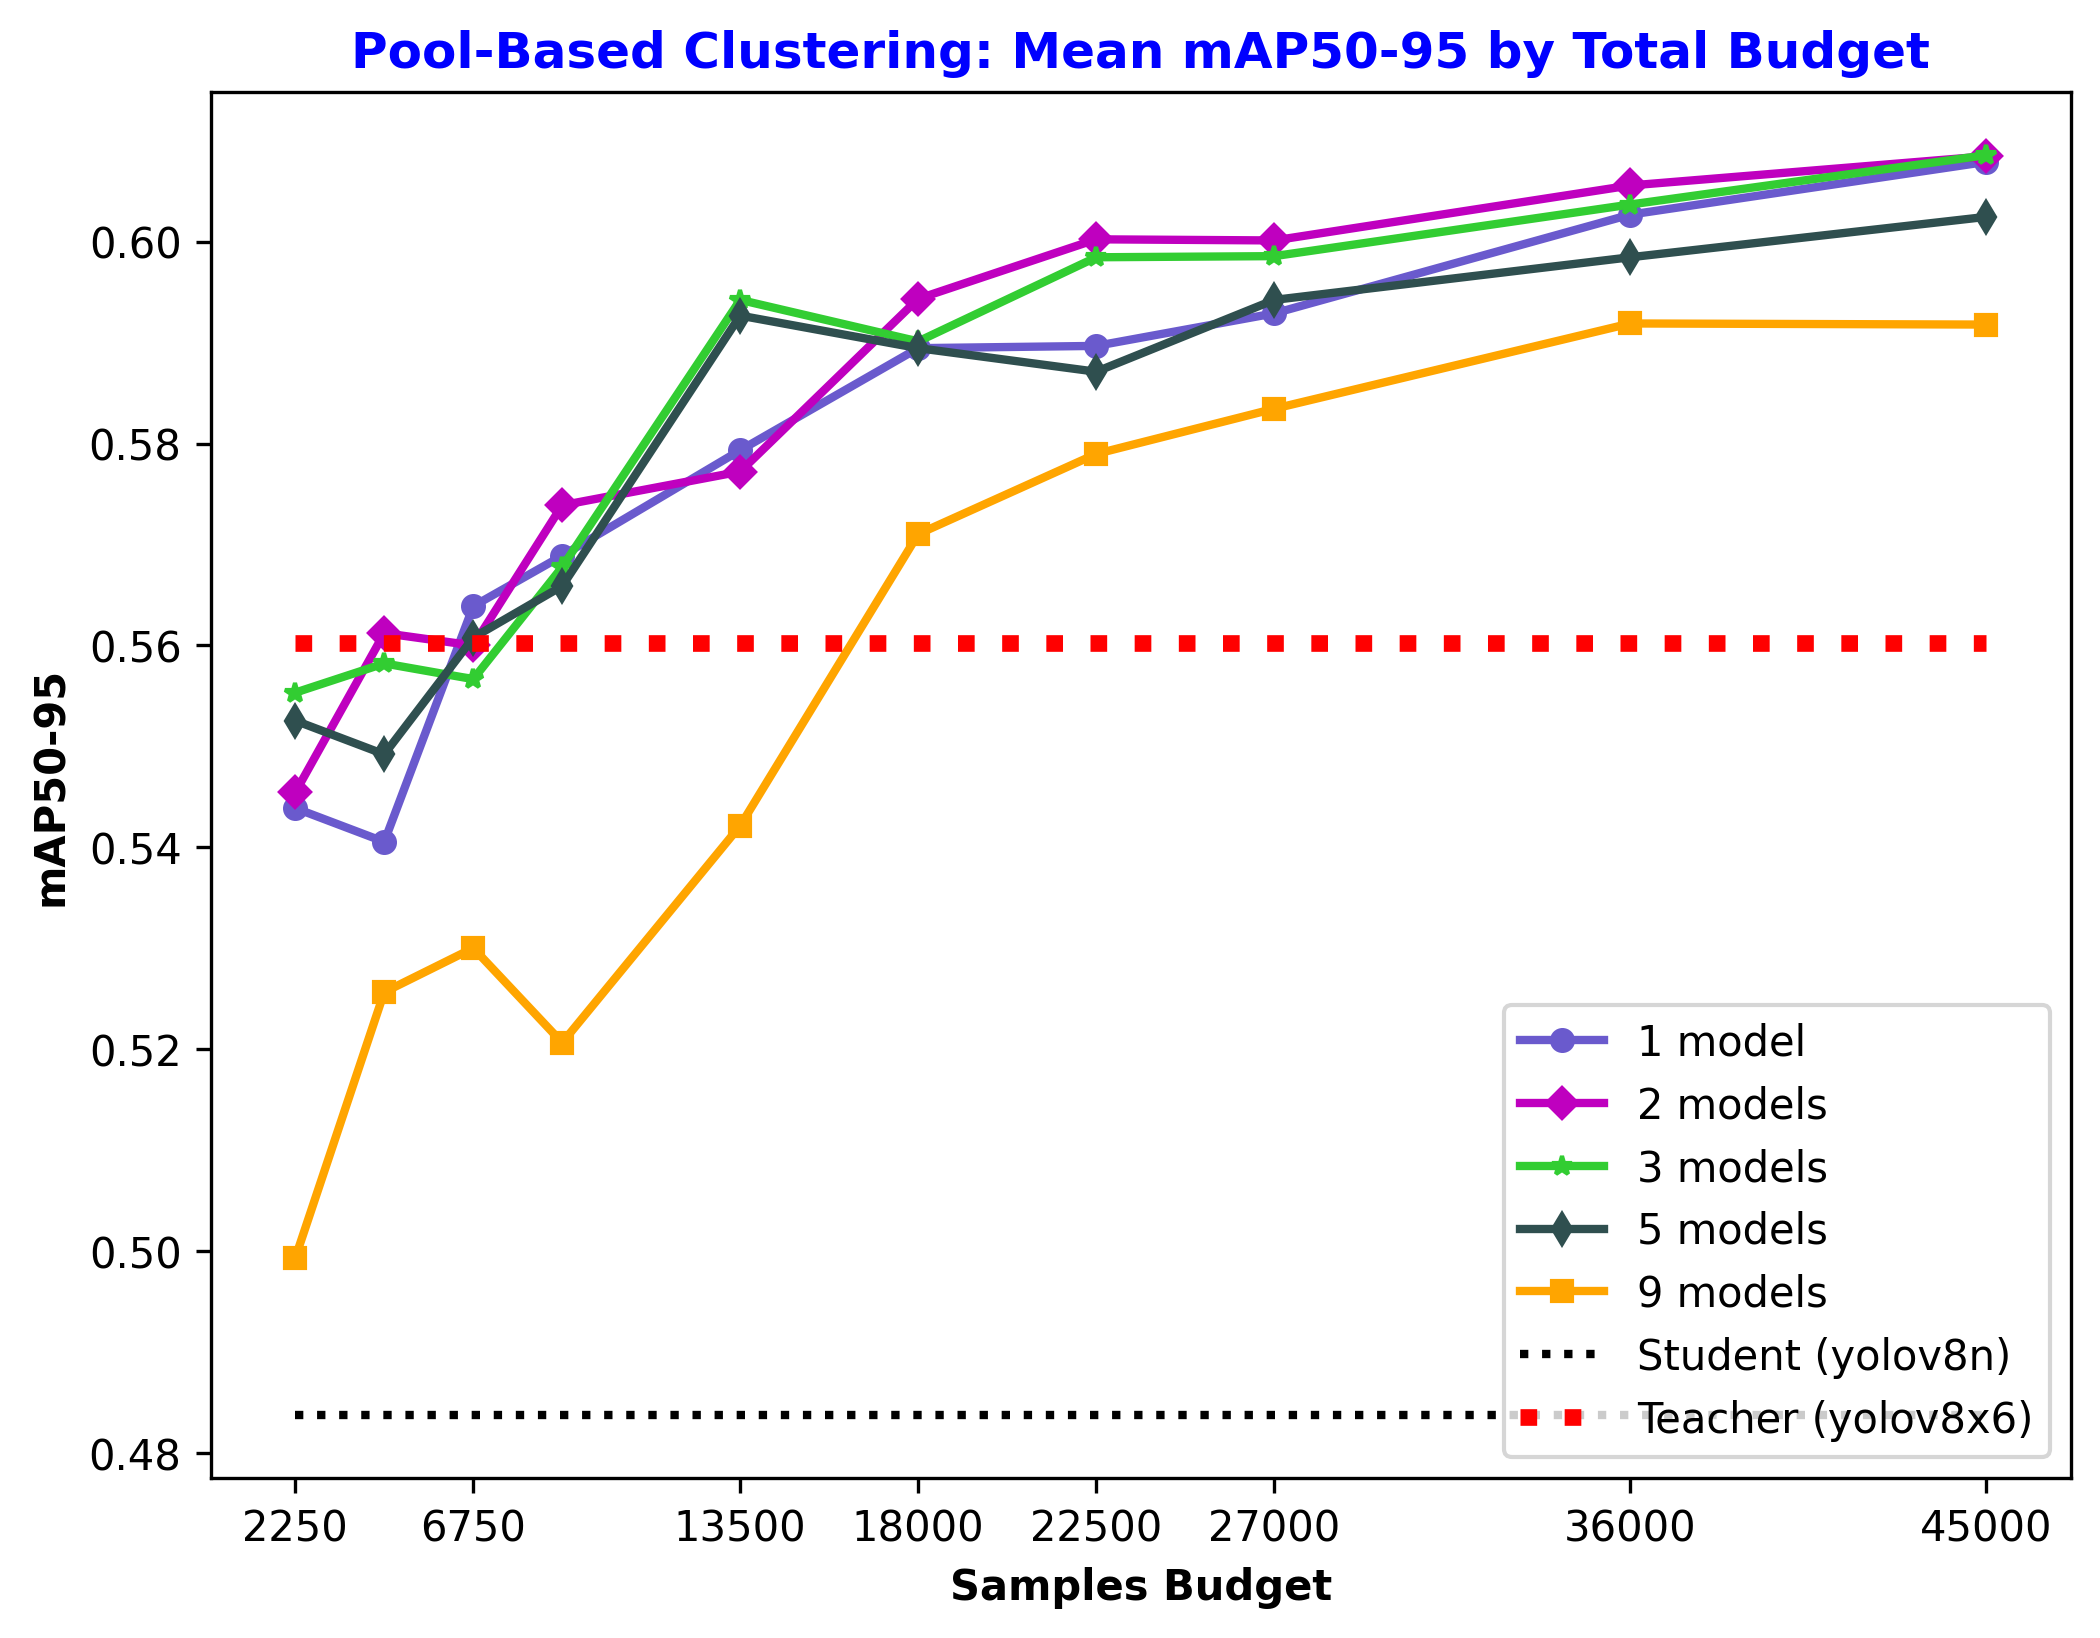

,mean_1-models,mean_2-models,mean_3-models,mean_5-models,mean_9-models,std_1-models,std_2-models,std_3-models,std_5-models,std_9-models,count_1-models,count_2-models,count_3-models,count_5-models,count_9-models
samples,,,,,,,,,,,,,,,
2250.000,0.544,0.545,0.555,0.553,0.499,0.102,0.101,0.104,0.102,0.104,9,9,9,9,9
4500.000,0.541,0.561,0.558,0.549,0.526,0.095,0.105,0.103,0.102,0.102,9,9,9,9,9
6750.000,0.564,0.560,0.557,0.561,0.530,0.096,0.103,0.103,0.093,0.107,9,9,9,9,9
9000.000,0.569,0.574,0.568,0.566,0.521,0.091,0.096,0.092,0.086,0.130,9,9,9,9,9
13500.000,0.579,0.577,0.594,0.593,0.542,0.088,0.083,0.079,0.089,0.111,9,9,9,9,9
18000.000,0.589,0.594,0.590,0.589,0.571,0.094,0.086,0.087,0.086,0.099,9,9,9,9,9
22500.000,0.590,0.600,0.598,0.587,0.579,0.098,0.095,0.096,0.093,0.093,9,9,9,9,9
27000.000,0.593,0.600,0.599,0.594,0.583,0.100,0.094,0.094,0.096,0.095,9,9,9,9,9
36000.000,0.603,0.606,0.604,0.598,0.592,0.099,0.094,0.093,0.093,0.096,9,9,9,9,9


In [99]:
df_cluster_pb = total_samples_cluster(restricted_dom_periods, 'top-confidence-max', samples_large, 
                                      df_all, restricted_dom_periods)

total_samples_pb = [x * 9 for x in samples_large]
todisplay=[total_samples_pb[0],
                       total_samples_pb[2],
                       total_samples_pb[4],
                       total_samples_pb[5],
                       total_samples_pb[6],
                       total_samples_pb[7],
                       total_samples_pb[8],total_samples_pb[9]]

plot_style={
    'tick_positions' : todisplay,
    'tick_labels':[str(value) for value in todisplay],
    'title': 'Pool-Based Clustering: Mean mAP50-95 by Total Budget',
    'setGrid': False,
    'filename':"E:\Download\images-journal\clusteringpool-based.pdf"
}

benchmark_strategies_plot(df_cluster_pb, 
                          strategy_styles=cluster_strategy_styles,
                          baseline_df=df_baseline_default,
                          baseline_styles=baseline_styles_default,
                          plot_style=plot_style)


df_result_cluster_pb = compute_pivot_tables(df_cluster_pb)
display(df_result_cluster_pb)

<h1> <font color="blue"> 5. Incremental deployment </font><h1>

<h1> <font color="blue"> 5.1 Generalisation loss of fine-tuned model</font><h1>

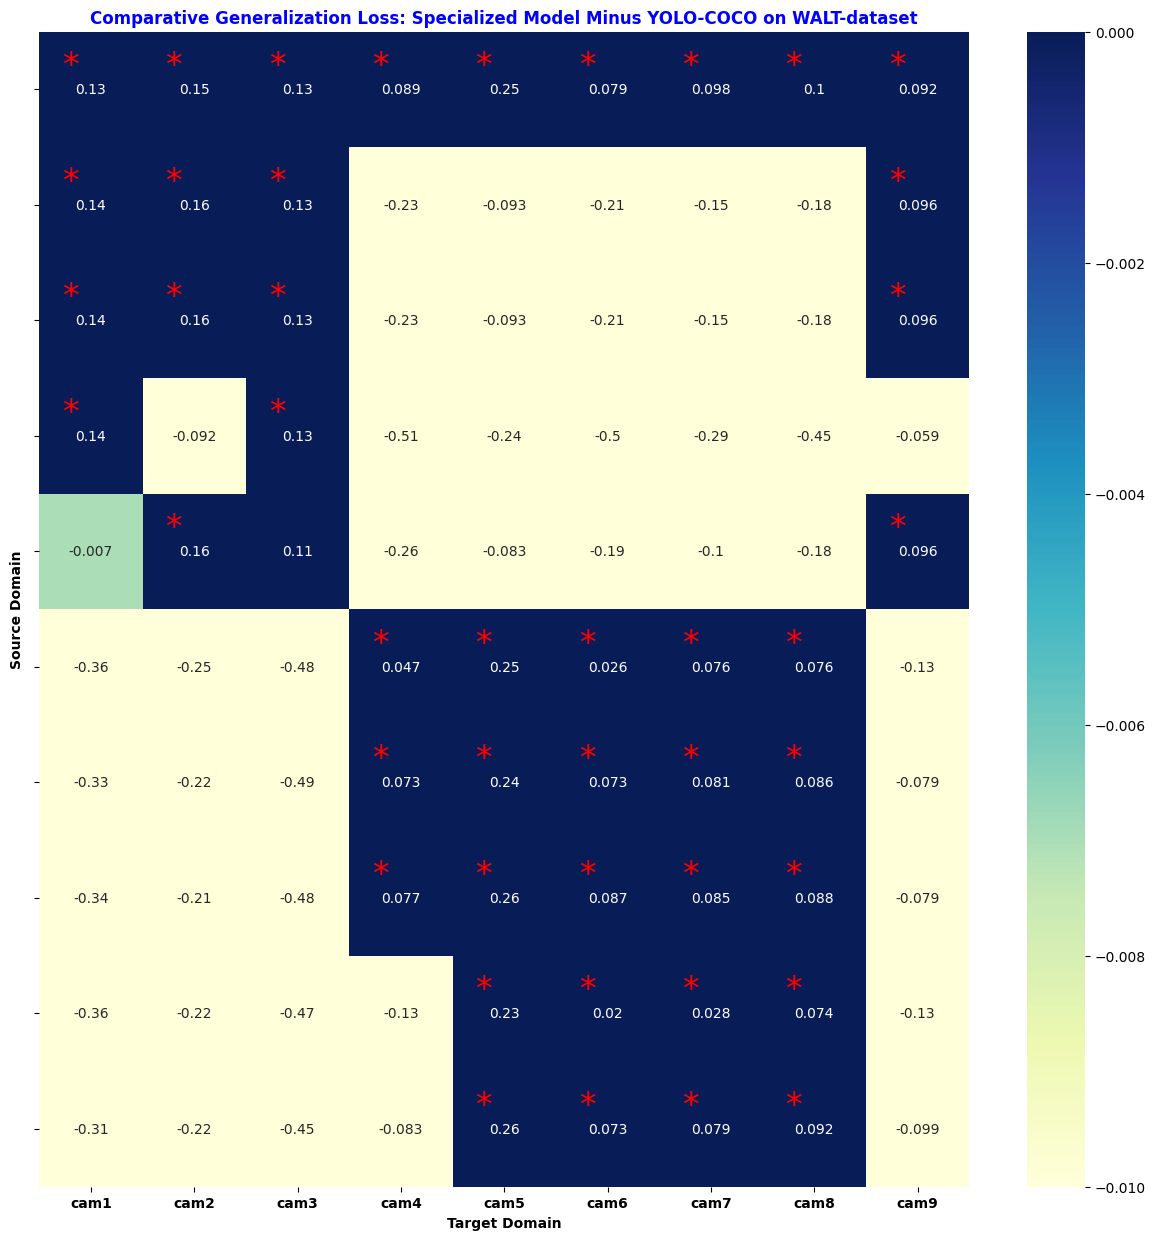

In [258]:
from matplotlib.patches import Rectangle

df_multistream['source_combo'] = list(zip(df_multistream['source_domain'], df_multistream['source_period'], df_multistream['samples']))# , ))#, df_multistream['student'], df_multistream['strategy'],))

samples_2iteration=[10000,24000,25000,45000,20000]
domains=['cam6o7o8','cam1o3','cam2o9','cam4o5o6o7o8','cam5o6o7o8','cam1o2o3o9','cam1o2o3o4o5o6o7o8o9','camo2o3o4o5o6o7o8o9']
student=['yolov8n']
strat=['top-confidence-max']
df_twoiteration_multistream,_,_ = filter_df(df_multistream,
                                            strategies=strat,
                                            students=student,
                                            source_domains=domains,
                                            samples=samples_2iteration)
grouped_df = df_twoiteration_multistream.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

#Plotting the first heatmap (without any adjustments)
#plt.figure(figsize=(15,15)) 
#sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
#plt.title('Heatmap between Source Domain and Target Domain')
#plt.xlabel('Target Domain')
#plt.ylabel('Source Domain')
#plt.show()


yolo_map50=yolov8n_df['mAP50-95']
#display(yolo_map50)


    
yolo_map50_list = yolo_map50.reset_index(drop=True).tolist()
pivot_df_s = pivot_df.apply(lambda row: row - yolo_map50_list, axis=1)
plt.figure(figsize=(15,15))
ax = sns.heatmap(pivot_df_s, annot=True, vmin=-0.01, vmax=0, cmap='YlGnBu')
plt.title('Comparative Generalization Loss: Specialized Model Minus YOLO-COCO on WALT-dataset', color="blue",weight="bold")
plt.xlabel('Target Domain', weight='bold')  # x-axis label in bold
plt.ylabel('Source Domain',weight='bold')

# Assume restricted_dom_periods is defined somewhere in your existing code
for i, row_val in enumerate(pivot_df_s.index):
    # Extract the source_domain and source_period from row_val if needed
    source_domain, source_period, samples = row_val  # Update this line based on your actual row_val structure
    # Compute inc_domains and out_domains for this source_domain
    _, inc_domains, _, _ = process_domains_periods(source_domain, source_period, restricted_dom_periods)
    
    for j, col_val in enumerate(pivot_df_s.columns):
        if any(domain in col_val for domain in inc_domains):
            ax.text(j+0.3, i+0.3, '*', color='red', ha='center', va='center', fontsize=24)
# Remove y-axis labels
ax.set_yticklabels([])
for label in ax.get_xticklabels():
    label.set_weight("bold")
plt.show()

<h1> <font color="blue"> 5.2. TWO -iterations fine-tuning, specialized students don't make them better learner </font><h1>


In the TWO-iteration fine-tuning experiment conducted hastily, two methodological errors were identified. First, the model used images based on the top-confidence of YOLOv8nano, rather than its own confidence level. Second, the model outperformed the teacher with a performance score of 0.60 compared to the teacher's 0.56.

Two alternative strategies were suggested:

Use images where the model has the highest confidence and rely on its own annotations.
Use images where the model has the lowest confidence and have them annotated by a human.
A subsequent test should be conducted on cameras 1, 2, 4, 6, 9, with samples ranging from 32 to 304, to see if using the model's own confidence improves performance.

A preliminary conclusion suggests that for effective distillation, there must be a performance gap between the teacher and the student; otherwise, the learning process could be negatively impacted. The exact quantification of this performance gap remains undefined.

Trying larger models is an option, but based on the current results, the approach is not recommended.

In [ ]:
samples = [45000]
strategy=['top-confidence-max']
strat_df,mean_strat,_= filter_df(df_multistream,
                    strategies=strategy, 
                    samples=samples,
                    source_domains=['cam1o2o3o4o5o6o7o8o9'])


stats_data = perform_statistical_tests(strat_df, yolov8n_df,'strategy','yolov8x6')

data = {'samples': samples, 
        'strategy': strategy, 
        'mean': mean_strat,
        'mean_yolov8n': mean_yolov8n,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
display(formatted_data)

<h1> <font color="blue"> 6. Domain-shift </font><h1>

What happens if a fine-tuned model is translated to a new domain? 

We observe under-performance. The development of context aware-models is necessary



Il faut un ré-entrainement sur la nouvelle caméra ajoutée 
en tenant compte des autres caméras. Le réapprentissage sur des nouvelles distributions et à prendre avec précaution. 

Spécialiser est risqué et s'il est possible de centraliser, nous recommandons de prendre une décision basée sur la heatmap. 
Partir d'un modèle spécialisé pour le fine-tuning est non recommandé. Il y'a quelque chose qu'on ne comprend pas. La spécialization est faite au détriment d'une généralization et donc le procédé doit être répété. à partir d'un modèle YOLO de base général. 
    

    La spécialisiation ne peut-être intéressante que si le modèle avait une base générale. Si le modèle est spécialisé. Il n'y aucun intérêt. 
    
    Dans un déploiement scalable
    
    
Domain specialization but at what price?

-SBAD remains a scalable approach but to guarantee the performance, the theta has to be a general purpose model.Two iterations fine-tuning

    The teacher has to be as general

[0.673, 0.48, 0.544, 0.395, 0.636, 0.646, 0.246]

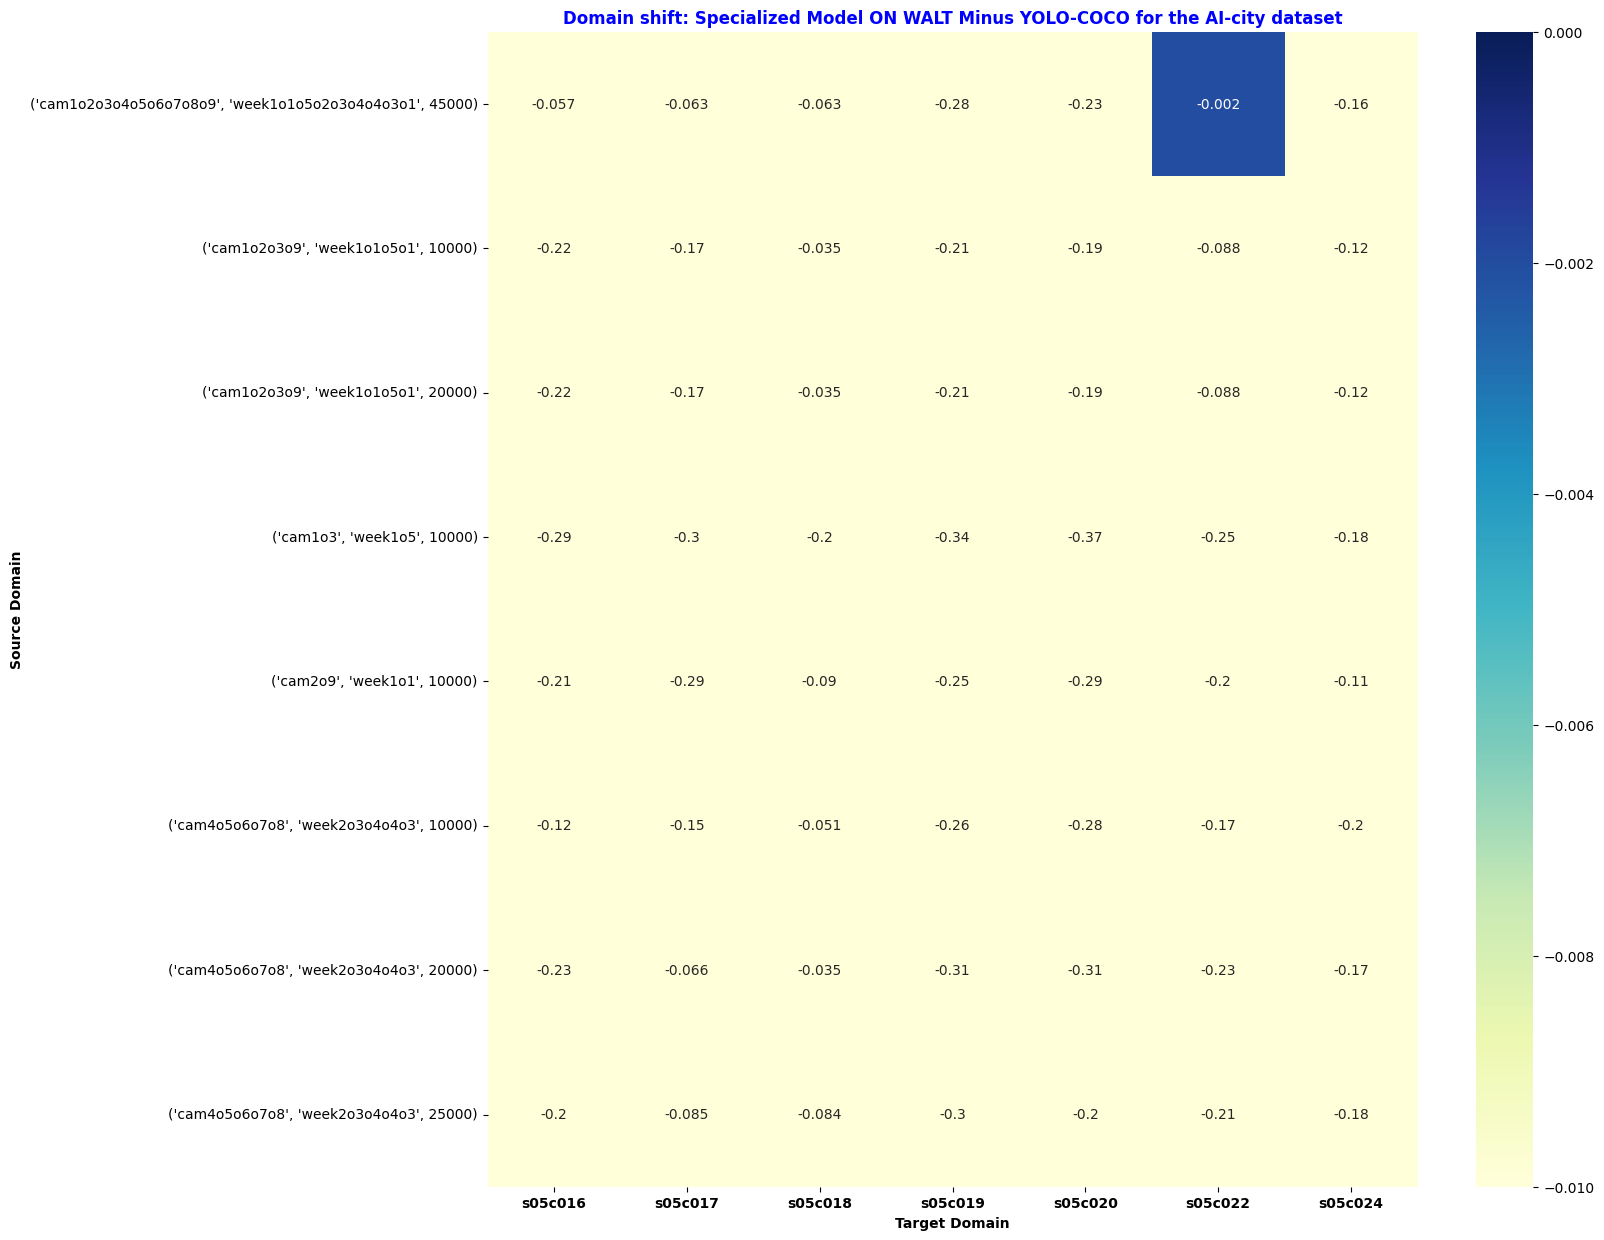

In [257]:
df_aicity['source_combo'] = list(zip(df_aicity['source_domain'], df_aicity['source_period'], df_aicity['samples']))# , ))#, df_multistream['student'], df_multistream['strategy'],))

samples_2iteration=[10000,25000,45000,20000]
domains=['cam6o7o8','cam1o3','cam2o9','cam4o5o6o7o8','cam5o6o7o8','cam1o2o3o9','cam1o2o3o4o5o6o7o8o9']
student=['yolov8n']
strat=['top-confidence-max']
df_domain_shift,_,_ = filter_df(df_aicity,
                                strategies=strat,
                                students=student,
                                source_domains=domains,
                                samples=samples_2iteration)
grouped_df = df_domain_shift.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

#Plotting the first heatmap (without any adjustments)
#plt.figure(figsize=(15,15)) 
#sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
#plt.title('Heatmap between Source Domain and Target Domain')
#plt.xlabel('Target Domain')
#plt.ylabel('Source Domain')
#plt.show()


df_yolov8n_aicity,_,_=filter_df(df_aicity,
                                strategies=['yolov8n'])
yolo_map50=df_yolov8n_aicity['mAP50-95']
yolo_map50_list = yolo_map50.reset_index(drop=True).tolist()
display(yolo_map50_list)
pivot_df_s = pivot_df.apply(lambda row: row - yolo_map50_list, axis=1)
plt.figure(figsize=(15,15))
ax = sns.heatmap(pivot_df_s, annot=True, vmin=-0.01, vmax=0, cmap='YlGnBu')
plt.title('Domain shift: Specialized Model ON WALT Minus YOLO-COCO for the AI-city dataset', color="blue",weight="bold")
plt.xlabel('Target Domain', weight='bold')  # x-axis label in bold
plt.ylabel('Source Domain',weight='bold')

# Assume restricted_dom_periods is defined somewhere in your existing code
for i, row_val in enumerate(pivot_df_s.index):
    # Extract the source_domain and source_period from row_val if needed
    source_domain, source_period, samples = row_val  # Update this line based on your actual row_val structure
    # Compute inc_domains and out_domains for this source_domain
    _, inc_domains, _, _ = process_domains_periods(source_domain, source_period, restricted_dom_periods)
    
    for j, col_val in enumerate(pivot_df_s.columns):
        if any(domain in col_val for domain in inc_domains):
            ax.text(j+0.3, i+0.3, '*', color='red', ha='center', va='center', fontsize=24)
# Remove y-axis labels
for label in ax.get_xticklabels():
    label.set_weight("bold")
plt.show()


<h1> <font color="blue"> Annex </font><h1>

<h2> <font color="blue"> A. Generation of side by side values for clustering </font><h2>

In [ ]:
def generate_df(cam_week_tuples, strategy, samples, df, df_multistream):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data={}
        cam, week = cam_week_tuple
        data["cam"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters)
        # Loop over each sample
        for sample in samples:
            data["smpls self"]=sample
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample])
            data["self"]=mean_cam_self
            for cls in inclusters:
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df_multistream, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam])
                
                data[f"smpls cls_{cls['number']}"]=number_of_samples
                data[f"cam cls_{cls['number']}"]=b
                data[f"mean cls_{cls['number']}"] = cluster_mean
                
            for cls in outclusters:
                anti_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], 
                                                               restricted_dom_periods)
                number_of_samples = len(anti_cameras)*sample
                data[f"anticam cls_{cls['number']}"]=b
                data[f"smpls anti_cls{cls['number']}"]=number_of_samples
                _,anticluster_mean,_= filter_df(df_multistream, 
                                                strategies=[strategy], 
                                                source_domains=[cls['source_domain']],
                                                source_periods=[cls['source_period']], 
                                                samples=[number_of_samples],
                                                target_domain=[cam])
                data[f"mean anticls_{cls['number']}"]=anticluster_mean
                # Append the results to the DataFrame
            result_df = pd.concat([result_df, pd.DataFrame([data])], ignore_index=True)
        
    return result_df


samples = [16,32,96,216]   # replace with your samples
df_cluster2 = generate_df(scal_dom_periods, 'thresholded-top-confidence-max', samples, df_stream, df_multistream)
display(df_cluster2)
grouped_df = df_cluster2.groupby(['smpls self']).mean(numeric_only=True)

<h2> <font color="blue"> B. Generation of side by side values for clustering (obsolete) </font><h2>

<h2> <font color="blue"> C. Same samples clustering different strategies of clustering </font><h2>

In [131]:
# Create an empty DataFrame for final results
final_results_df = pd.DataFrame()
for cluster in clusters:
    results_df = analyze_performance(cluster["number"], 
                                     selected_strategy, 
                                     selected_sample_sizes,  
                                     cluster["source_domain"], 
                                     cluster["source_period"],
                                     restricted_dom_periods,
                                     df_stream,
                                     df_multistream)
    final_results_df = pd.concat([final_results_df, results_df])


display(final_results_df)

,samples,strategy,mean self,mean multi,cluster numbers,cameras,t-statistic,p-value,T-test result,shapiro-wilk single-stream,...,p-value_excl,T-test result_excl,shapiro-wilk single-stream_excl,shapiro-wilk single-stream result_excl,shapiro-wilk multi-stream_excl,shapiro-wilk multi-stream result_excl,levene_excl,levene result_excl,mann-whitney u_excl,mann-whitney u result_excl
0,96,n-first,0.352,0.413,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",-0.902,0.380,Means statistically undifferent,0.461,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
1,96,uniform-random-0,0.468,0.372,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",1.588,0.132,Means statistically undifferent,0.280,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
2,96,thresholded-top-confidence-max,0.502,0.480,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.379,0.709,Means statistically undifferent,0.007,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
3,216,n-first,0.383,0.423,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",-0.605,0.554,Means statistically undifferent,0.026,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
4,216,uniform-random-0,0.472,0.425,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.638,0.533,Means statistically undifferent,0.003,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,96,uniform-random-0,0.228,NaN,5,cam5,NaN,NaN,Not testable,NaN,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
2,96,thresholded-top-confidence-max,0.369,NaN,5,cam5,NaN,NaN,Not testable,NaN,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
3,216,n-first,0.001,NaN,5,cam5,NaN,NaN,Not testable,NaN,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
4,216,uniform-random-0,0.031,NaN,5,cam5,NaN,NaN,Not testable,NaN,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
